In [1]:
# Import relevant libraries.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
stop_words = set(stopwords.words('english'))

# Ignore

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jonny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jonny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jonny\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jonny\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Data Exploration

In [2]:
# Load dataset. 
df = pd.read_csv('all_speeches.csv')

In [3]:
# View DataFrame
df.head(5)

,reference,country,date,title,author,is_gov,text
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh..."


In [4]:
# View shape
df.shape

(7721, 7)

In [5]:
# Print info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [6]:
# Look at speeches by country / area
df.country.value_counts()

country
euro area         2351
united states     1551
united kingdom    1209
japan              755
canada             620
sweden             600
switzerland        351
australia          284
Name: count, dtype: int64

In [7]:
# Check for duplicates
df.duplicated().sum()

0

In [8]:
# Check for duplicates in text column
df['text'].duplicated().sum()

29

In [9]:
# Determine the metadata of the data set.
df.dtypes

reference    object
country      object
date         object
title        object
author       object
is_gov        int64
text         object
dtype: object

In [10]:
# Create an empty DataFrame
df_date = pd.DataFrame(columns = ['year', 'month', 'day'])

# Split out the date to see how it's formatted.
df_date[['year', 'month', 'day']] = df['date'].str.split('-', expand=True)

In [11]:
# View max and min in month column. 
print(f"Min Month: {df_date['month'].min()}")
print(f"Max Month: {df_date['month'].max()}")

# Day
print(f"Min Day: {df_date['day'].min()}")
print(f"Max Day: {df_date['day'].max()}")

# Year
print(f"Min Year: {df_date['year'].min()}")
print(f"Max Year: {df_date['year'].max()}")

Min Month: 01
Max Month: 12
Min Day: 01
Max Day: 31
Min Year: 1900
Max Year: 2022


In [12]:
# Convert date to date time format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Check
df.dtypes

reference            object
country              object
date         datetime64[ns]
title                object
author               object
is_gov                int64
text                 object
dtype: object

In [13]:
# Adding a column to calculate the string length per speech.
df['len'] = df['text'].str.len()

In [14]:
# Adding a month column that takes the month of each speech
df['year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m')) 
df['year'] = df['date'].apply(lambda x: x.strftime('%Y'))

# Return the weekday of the date (e.g., 'Monday', 'Tuesday', etc.)
df['weekday'] = df['date'].dt.day_name()

df['quarter'] = pd.PeriodIndex(df.date, freq='Q')

# Sort
df = df[['reference', 'country', 'date', 'quarter', 'year_month', 'weekday', 'year', 'title', 'author', 'is_gov', 'text', 'len']]

### UK Subset

In [15]:
# View UK subset
df[df['country']=='united kingdom'].sort_values('date').head(10)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,text,len
4961,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09,Tuesday,1998,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",13731
4962,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,24263
4963,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,13678
4964,r981101a_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,27679
4965,r981101b_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",27693
4966,r981119a_BOE,united kingdom,1998-11-19,1998Q4,1998-11,Thursday,1998,Speech,george,0,Let me put some of the recent newspaper headli...,13298
4967,r981201a_BOE,united kingdom,1998-12-01,1998Q4,1998-12,Tuesday,1998,Speech,governor,0,It is both an honour and a challenge to delive...,36920
4968,r981215a_BOE,united kingdom,1998-12-15,1998Q4,1998-12,Tuesday,1998,Alice in Euroland,buiter,0,Economic and Monetary Union has arrived de fac...,28791
4969,r990112a_BOE,united kingdom,1999-01-12,1999Q1,1999-01,Tuesday,1999,Speech,george,0,I am only too well aware of the pressure curre...,14819
4970,r990118a_BOE,united kingdom,1999-01-18,1999Q1,1999-01,Monday,1999,Speech,george,0,It would be a masterly understatement to descr...,14448


In [16]:
# Creating a new DataFrame with only UK speeches.
df_uk = df[df['country']=='united kingdom']

In [17]:
# View
df_uk.tail(5)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,text,len
6165,r221007a_BOE,united kingdom,2022-10-07,2022Q4,2022-10,Friday,2022,"Shocks, inflation, and the policy response",ramsden,0,Thank you very much for the invitation to spea...,24773
6166,r221012a_BOE,united kingdom,2022-10-12,2022Q4,2022-10,Wednesday,2022,Monetary policy: an anchor in challenging times,pill,0,Huw Pill talks about how we will bring inflati...,22398
6167,r221015a_BOE,united kingdom,2022-10-15,2022Q4,2022-10,Saturday,2022,Monetary policy and financial stability interv...,bailey,1,We are meeting in the most difficult of times....,10270
6168,r221019a_BOE,united kingdom,2022-10-19,2022Q4,2022-10,Wednesday,2022,"Governance of “Decentralised” Finance: Get up,...",wilkins,0,"These are divided into seven categories, suffr...",33040
6169,r221020a_BOE,united kingdom,2022-10-20,2022Q4,2022-10,Thursday,2022,The inflationary consequences of real shocks,broadbent,0,"Between them, the Covid-19 pandemic and Russia...",36006


In [18]:
# View shape
df_uk.shape

# Reset index
df_uk = df_uk.reset_index(drop=True)

In [19]:
# View max and min in date column. 
print(f"Min Month: {df_uk['date'].min()}")
print(f"Max Month: {df_uk['date'].max()}")

Min Month: 1998-09-15 00:00:00
Max Month: 2022-10-20 00:00:00


In [20]:
# Check for duplicates in text column
df_uk['text'].duplicated().sum()

7

In [21]:
# Print the duplicate speeches
df_uk_dupe = df_uk[df_uk['text'].duplicated(keep=False)].sort_values(by='text')
df_uk_dupe

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,text,len
1121,r210429b_BOE,united kingdom,2021-04-29,2021Q2,2021-04,Thursday,2021,Developments in the PRA’s supervision of annui...,gerken,0,Asset eligibility Liability eligibility Calcul...,90583
1181,r220526a_BOE,united kingdom,2022-05-26,2022Q2,2022-05,Thursday,2022,Four Rs: Creating the conditions for long-term...,gerken,0,Asset eligibility Liability eligibility Calcul...,90583
697,r150226a_BOE,united kingdom,2015-02-26,2015Q1,2015-02,Thursday,2015,"Goodbye ambiguity, hello clarity: the Bank of ...",shafik,0,Bank of England's relationship with financial ...,24134
1120,r210421a_BOE,united kingdom,2021-04-21,2021Q2,2021-04,Wednesday,2021,Opening remarks: meeting varied people,rosen,0,Bank of England's relationship with financial ...,24134
991,r190517a_BOE,united kingdom,2019-05-17,2019Q2,2019-05,Friday,2019,"Citizens in service, not people in power",brazier,0,Dimitri Demekas and Paul Tucker for helpful di...,17444
1174,r220428a_BOE,united kingdom,2022-04-28,2022Q2,2022-04,Thursday,2022,Macropru,breeden,0,Dimitri Demekas and Paul Tucker for helpful di...,17444
242,r061024a_BOE,united kingdom,2006-10-24,2006Q4,2006-10,Tuesday,2006,Globalisation and Inflation,bean,0,"Madonna"", given the 90 million hits that her n...",26684
1159,r211203a_BOE,united kingdom,2021-12-03,2021Q4,2021-12,Friday,2021,The outlook for inflation and monetary policy,saunders,0,"Madonna"", given the 90 million hits that her n...",26684
1074,r200903a_BOE,united kingdom,2020-09-03,2020Q3,2020-09,Thursday,2020,Reinventing the wheel (with more automation),bailey,1,The Covid-19 pandemic is having a severely dis...,239461
1077,r200909a_BOE,united kingdom,2020-09-09,2020Q3,2020-09,Wednesday,2020,Paving the way forward: managing climate risk ...,sweeney,0,The Covid-19 pandemic is having a severely dis...,239461


### Analysing Sentiment: FinBERT Model

In [22]:
import scipy
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [23]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [24]:
def finbert_sentiment(text: str) -> tuple[float, float, float, str]:
    with torch.no_grad():
        
        # Tokenize the input text
        inputs = tokenizer(
            text, return_tensors="pt", padding=True, truncation=True, max_length=512
        )
        
        # Forward pass through the model
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Calculate softmax scores
        softmax_scores = scipy.special.softmax(logits.numpy(), axis=1).squeeze()

        # Create a dictionary with the sentiment scores
        scores = {
            model.config.id2label[i]: softmax_scores[i] for i in range(len(softmax_scores))
        }

        # Return the scores for positive, negative, and neutral, along with the predicted sentiment
        return (
            scores.get('positive', 0.0),
            scores.get('negative', 0.0),
            scores.get('neutral', 0.0),
            max(scores, key=scores.get),
        )

In [25]:
# Import
bert_sentiment_uk = pd.read_csv('bert_sentiment_uk.csv')

In [26]:
# View
bert_sentiment_uk.head(5)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,team_sentiment
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09-01,Tuesday,1998,Speech,george,0,13731,thank you chairman im actually very pleased to...,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",0.087535,0.325207,0.587258,neutral,-0.237672,neutral-negative
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Britain in Europe,george,0,24263,its a great pleasure to be here in the beautif...,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",0.212209,0.017505,0.770286,neutral,0.194704,neutral-positive
2,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,13678,few industries have suffered more from volatil...,"['few', 'industries', 'have', 'suffered', 'mor...","['industries', 'suffered', 'volatility', 'brit...",0.047679,0.476351,0.475970,negative,-0.428672,negative
3,r981101a_BOE,united kingdom,1998-11-01,1998Q4,1998-11-01,Sunday,1998,"Economic policy, with and without forecasts",budd,0,27679,my topic this evening is the use of forecasts ...,"['my', 'topic', 'this', 'evening', 'is', 'the'...","['topic', 'evening', 'use', 'forecasts', 'econ...",0.046829,0.049165,0.904007,neutral,-0.002336,neutral
4,r981101b_BOE,united kingdom,1998-11-01,1998Q4,1998-11-01,Sunday,1998,Inflation targeting in practice: the UK experi...,vickers,0,27693,six years ago this week sterling left the exch...,"['six', 'years', 'ago', 'this', 'week', 'sterl...","['six', 'years', 'ago', 'week', 'sterling', 'l...",0.035134,0.049842,0.915023,neutral,-0.014708,neutral


In [27]:
# Shape
bert_sentiment_uk.shape

# Convert to DateTime
bert_sentiment_uk['date'] = pd.to_datetime(bert_sentiment_uk['date'])
bert_sentiment_uk['year_month'] = pd.to_datetime(bert_sentiment_uk['year_month'])
bert_sentiment_uk['quarter'] = pd.PeriodIndex(bert_sentiment_uk['date'], freq='Q')

In [28]:
# Function for new classification
def classify_neu(row):

    sentiment = row['finbert_sentiment']
    score = row['finbert_score']

    if sentiment == 'neutral':
        if score > 0.1:
            return 'neutral-positive'
        elif score < -0.1:
            return 'neutral-negative'
        else:
            return 'neutral'
    else:
        return sentiment

# Apply function 
bert_sentiment_uk['team_sentiment'] = bert_sentiment_uk.apply(classify_neu, axis=1)

In [29]:
# View
bert_sentiment_uk.head(2)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,team_sentiment
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09-01,Tuesday,1998,Speech,george,0,13731,thank you chairman im actually very pleased to...,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",0.087535,0.325207,0.587258,neutral,-0.237672,neutral-negative
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Britain in Europe,george,0,24263,its a great pleasure to be here in the beautif...,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",0.212209,0.017505,0.770286,neutral,0.194704,neutral-positive


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Total UK Speeches by FinBERT Sentiment Category')

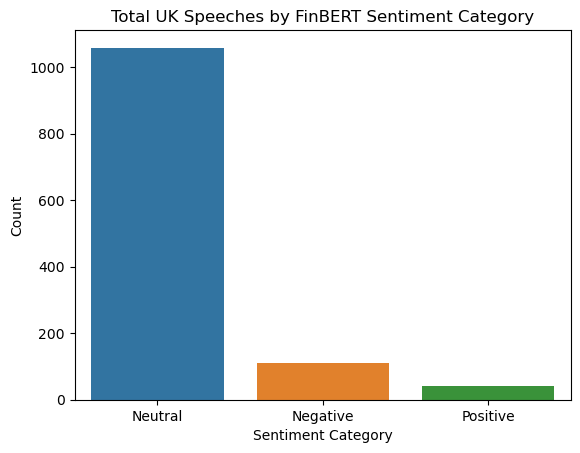

In [31]:
# Plot
ax = sns.countplot(x='finbert_sentiment', data=bert_sentiment_uk)

# Set labels
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

# X labels
ax.set_xticklabels(['Neutral', 'Negative', 'Positive'])

# Set title
plt.title('Total UK Speeches by FinBERT Sentiment Category')

In [32]:
# Sentiment distribution (All speeches)
bert_counts = bert_sentiment_uk['finbert_sentiment'].value_counts()

# Calculate the percentage distribution
print((bert_counts / bert_counts.sum()) * 100)

finbert_sentiment
neutral     87.510339
negative     9.181141
positive     3.308519
Name: count, dtype: float64


Text(0.5, 1.0, 'Total UK Speeches by Team Sentiment Category')

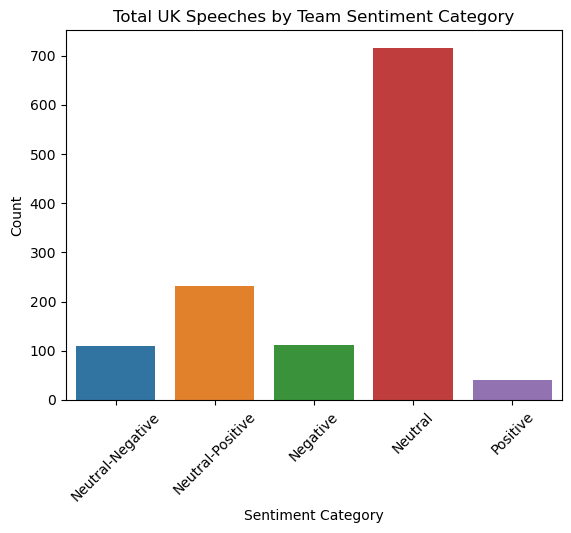

In [33]:
# Plot
ax = sns.countplot(x='team_sentiment', data=bert_sentiment_uk)

# Set labels
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

# X labels
ax.set_xticklabels(['Neutral-Negative', 'Neutral-Positive', 'Negative', 'Neutral', 'Positive'], rotation=45)

# Set title
plt.title('Total UK Speeches by Team Sentiment Category')

In [34]:
# Sentiment distribution (All speeches)
team_counts = bert_sentiment_uk['team_sentiment'].value_counts()

# Calculate the percentage distribution
print((team_counts / team_counts.sum()) * 100)

team_sentiment
neutral             59.222498
neutral-positive    19.189413
negative             9.181141
neutral-negative     9.098428
positive             3.308519
Name: count, dtype: float64


In [35]:
import matplotlib.dates as mdates

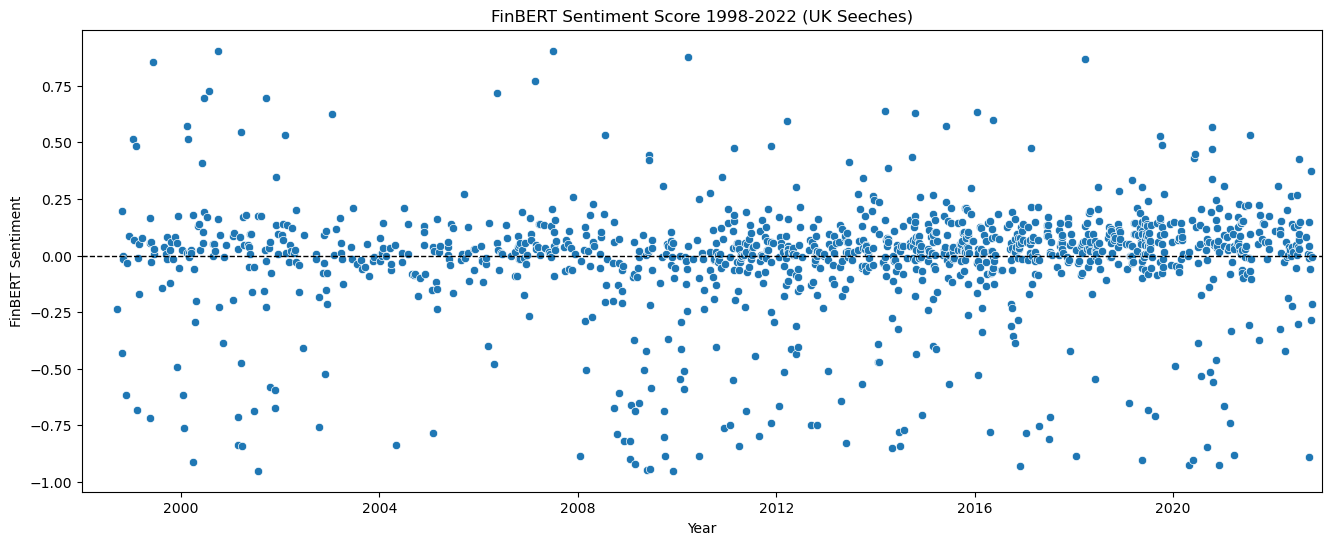

In [36]:
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=bert_sentiment_uk, x='date', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# X-Axis Limit
ax.set_xlim([pd.Timestamp('1998-01-01'), pd.Timestamp('2022-12-31')])

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('FinBERT Sentiment Score 1998-2022 (UK Seeches)')

# Display the plot
plt.show()

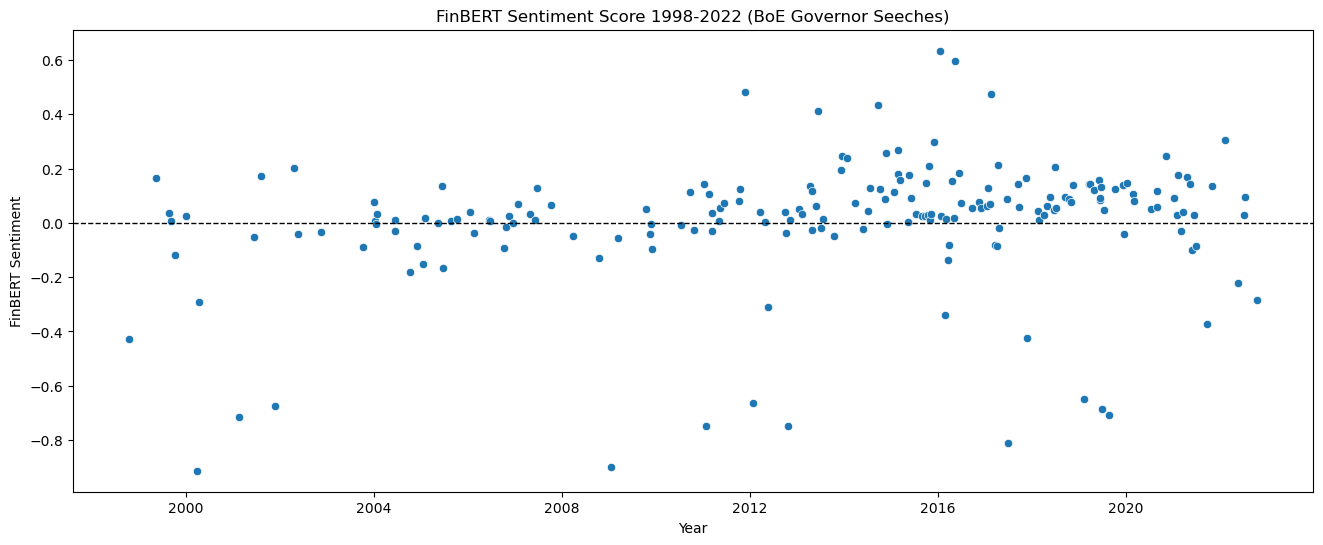

In [37]:
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1], x='date', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('FinBERT Sentiment Score 1998-2022 (BoE Governor Seeches)')

# Display the plot
plt.show()

In [38]:
# Create monthly average DataFrame
avg_bert = pd.DataFrame(bert_sentiment_uk.groupby('year_month')['finbert_score'].mean())

# Create quarterly average DataFrame
quart_bert = bert_sentiment_uk.groupby('quarter')['finbert_score'].mean().reset_index()
quart_bert['quarter'] = quart_bert['quarter'].dt.to_timestamp()

# Create monthly average DataFrame
avg_bert_gov = pd.DataFrame(bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1].groupby('year_month')['finbert_score'].mean())

# Create quarterly average DataFrame
quart_bert_gov = bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1].groupby('quarter')['finbert_score'].mean().reset_index()
quart_bert_gov['quarter'] = quart_bert_gov['quarter'].dt.to_timestamp()

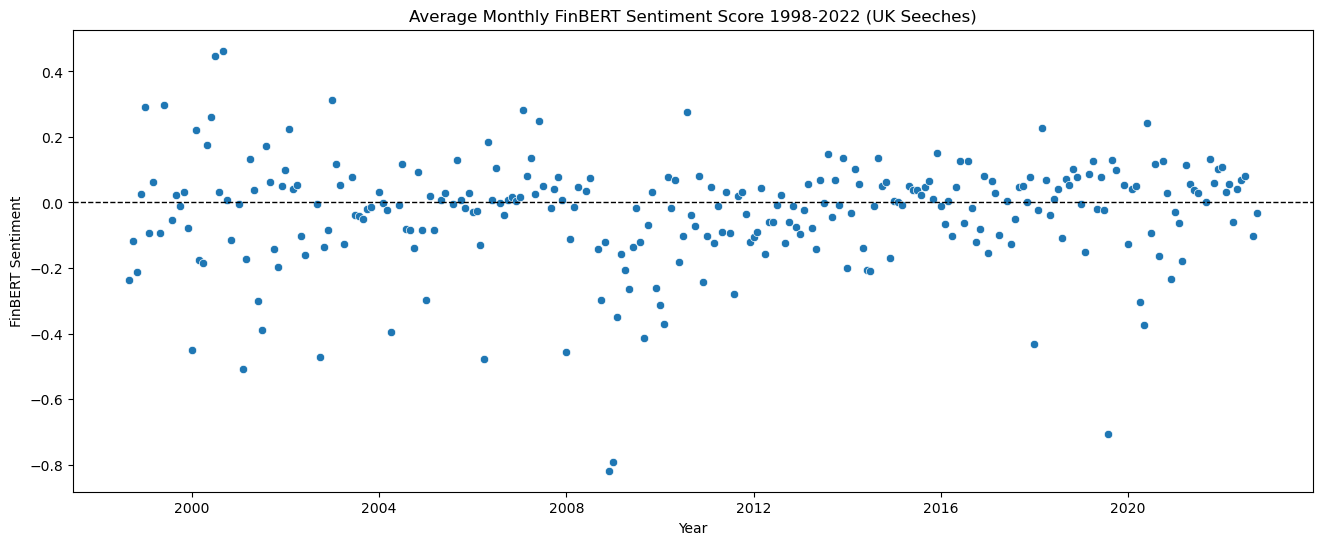

In [39]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=avg_bert, x='year_month', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Monthly FinBERT Sentiment Score 1998-2022 (UK Seeches)')

# Display the plot
plt.show()

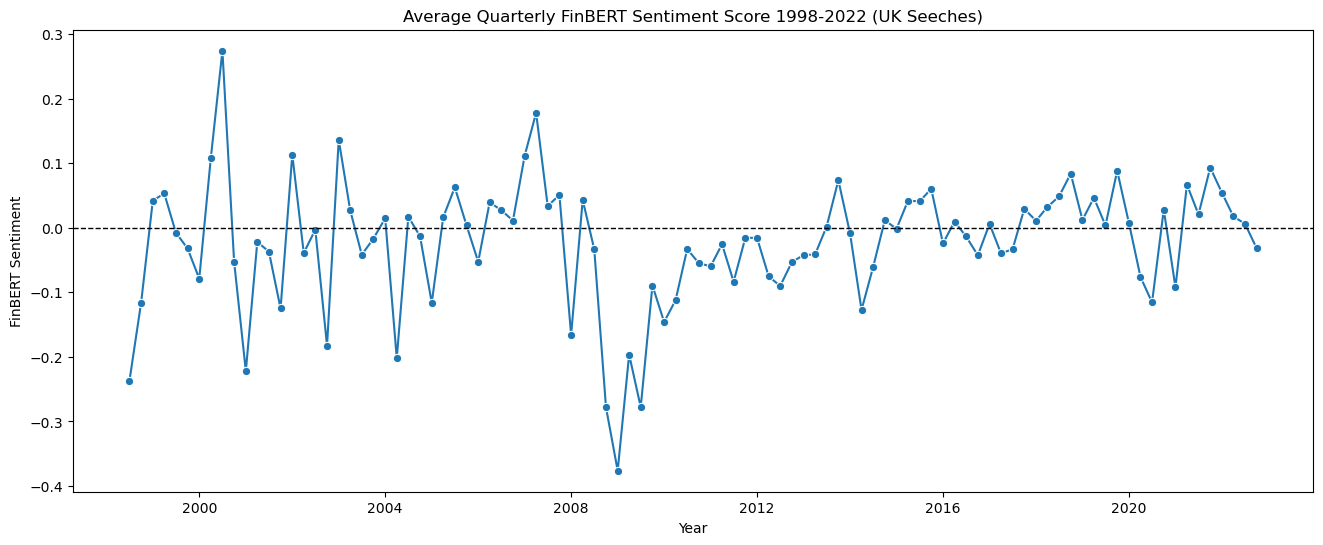

In [40]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=quart_bert, x='quarter', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Quarterly FinBERT Sentiment Score 1998-2022 (UK Seeches)')

# Display the plot
plt.show()

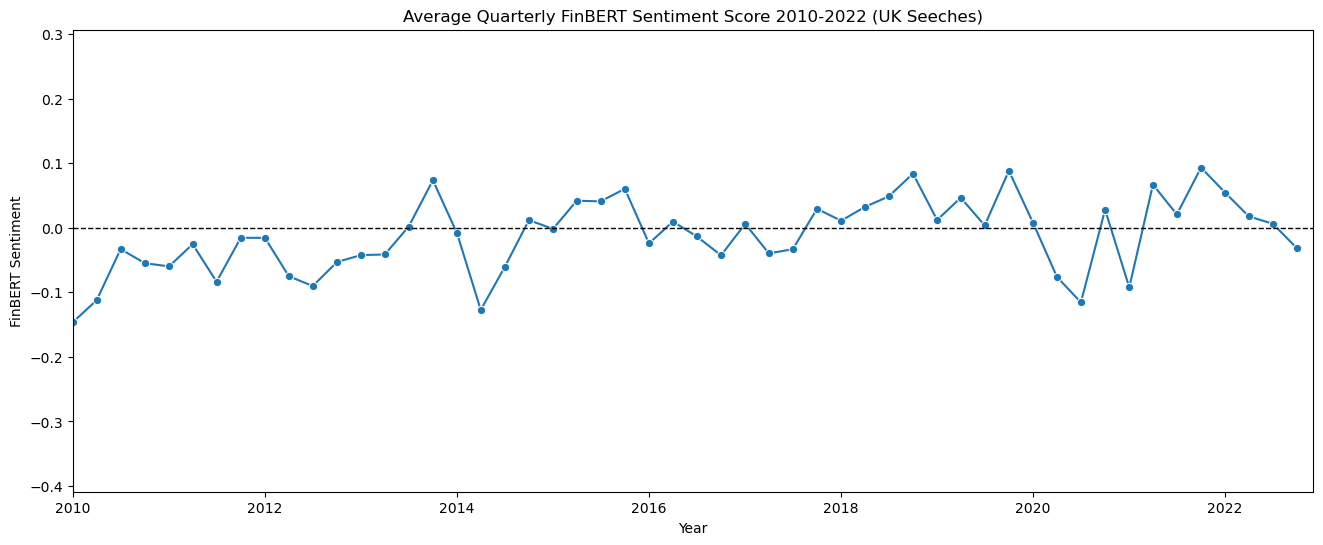

In [41]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=quart_bert, x='quarter', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set x-axis limits
ax.set_xlim([pd.to_datetime('2010-01-01'), pd.to_datetime('2022-12-01')])

# Set title
plt.title('Average Quarterly FinBERT Sentiment Score 2010-2022 (UK Seeches)')

# Display the plot
plt.show()

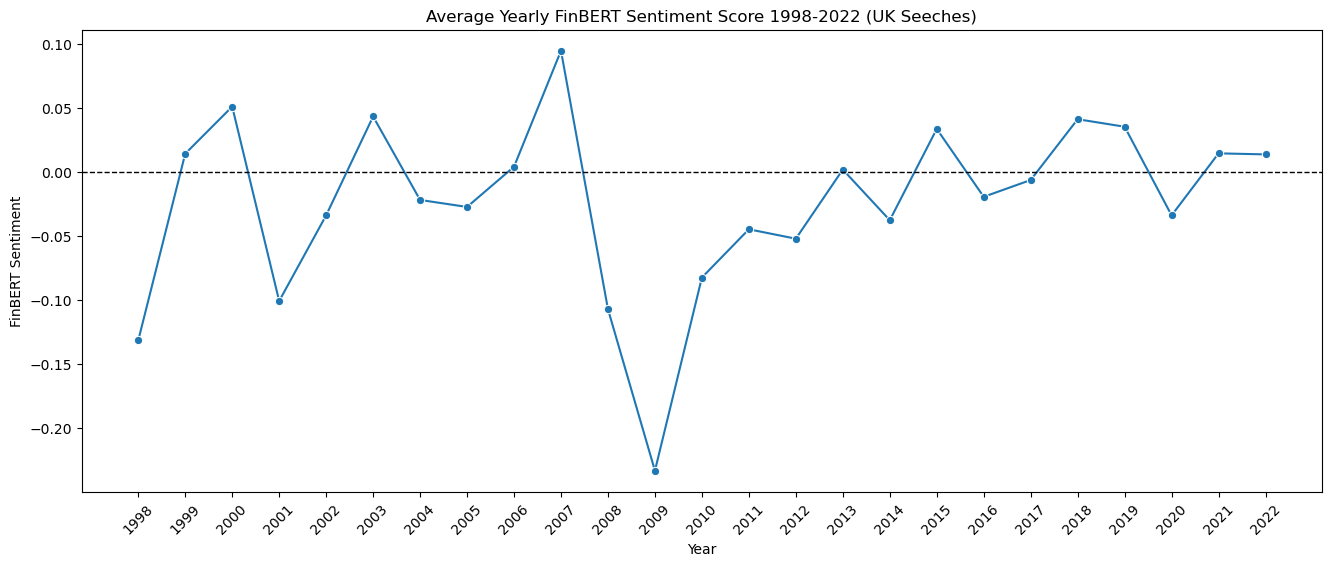

In [42]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=bert_sentiment_uk.groupby('year')['finbert_score'].mean().reset_index(), x='year', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set the x-ticks
years = bert_sentiment_uk['year'].unique()
plt.xticks(ticks=years, rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Yearly FinBERT Sentiment Score 1998-2022 (UK Seeches)')

# Display the plot
plt.show()

In [43]:
# Import necessary modules
from sklearn.metrics import mean_absolute_error

# Function to plot moving average
# Scale - The default value corresponds to a 95% confidence interval assuming a normal distribution
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(16,6))
    plt.title("Moving Average\n Window Size = {}".format(window))
    plt.xlabel('Year')
    plt.ylabel('FinBERT Sentiment Score')
    plt.plot(rolling_mean, 'b', label='SMA')

    # Date format
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    date_format = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45)

    # Adding a horizontal dashed line at y=0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    # Plot confidence intervals
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
    plt.legend(loc='best')
    plt.grid(True)

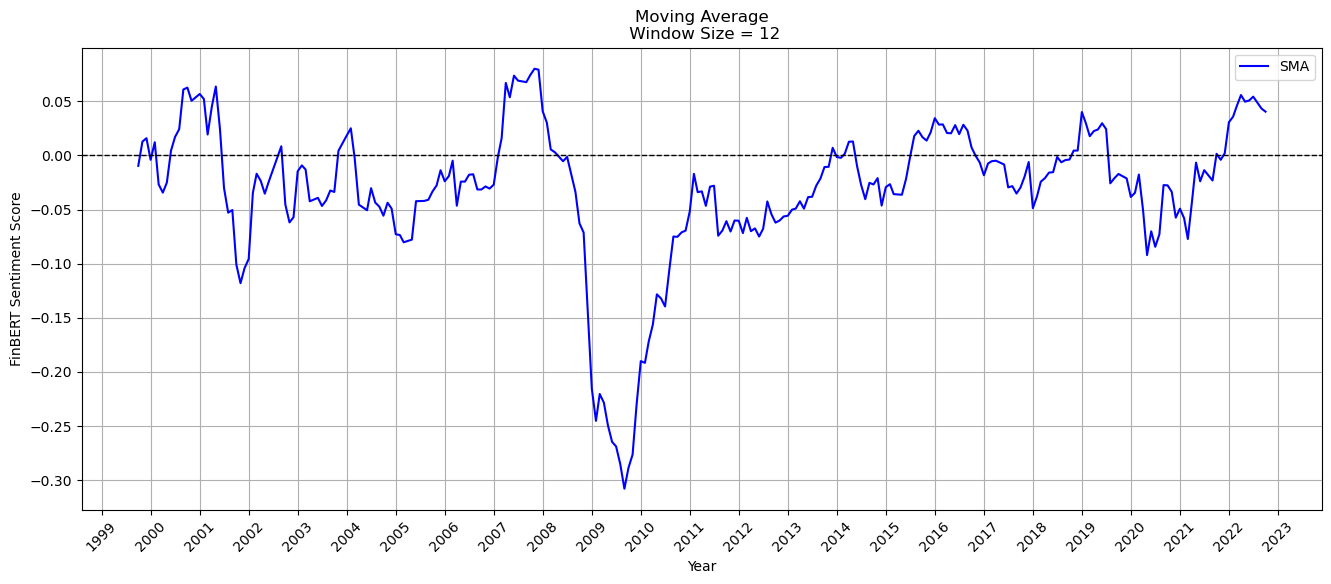

In [44]:
# 12 Month
plot_moving_average(avg_bert, 12, plot_intervals=False)

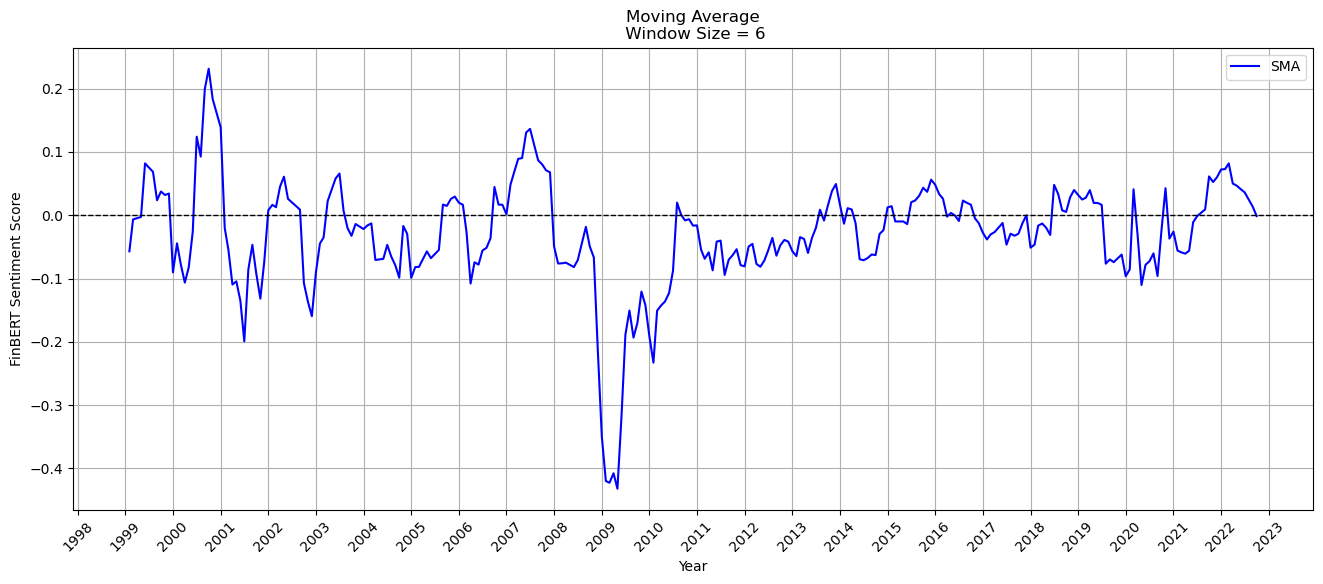

In [45]:
# 6 Month
plot_moving_average(avg_bert, 6, plot_intervals=False)

In [46]:
# Create monthly average DataFrame for Governor Speeches
avg_bert_gov = pd.DataFrame(bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1].groupby('year_month')['finbert_score'].mean())

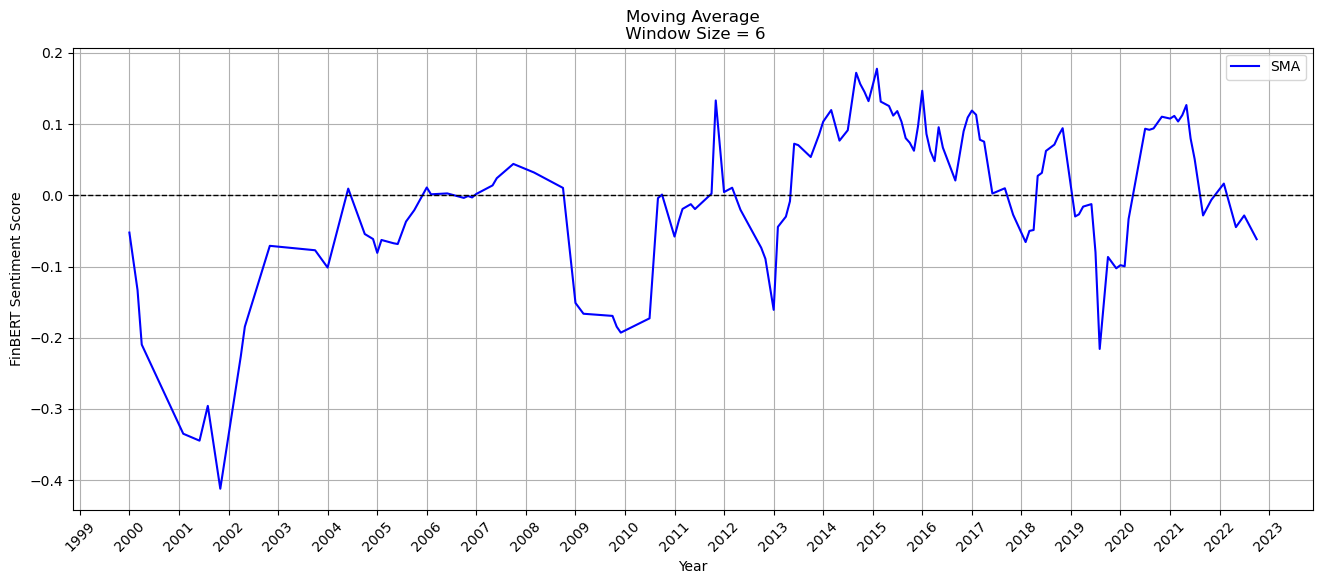

In [47]:
# 6 Month
plot_moving_average(avg_bert_gov, 6, plot_intervals=False)

In [48]:
# Only positive / negative speeches
pos_neg_bert_uk = bert_sentiment_uk[bert_sentiment_uk['finbert_sentiment'] != 'neutral']

# View
pos_neg_bert_uk.head(2)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,team_sentiment
2,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,13678,few industries have suffered more from volatil...,"['few', 'industries', 'have', 'suffered', 'mor...","['industries', 'suffered', 'volatility', 'brit...",0.047679,0.476351,0.475970,negative,-0.428672,negative
5,r981119a_BOE,united kingdom,1998-11-19,1998Q4,1998-11-01,Thursday,1998,Speech,george,0,13298,let me put some of the recent newspaper headli...,"['let', 'me', 'put', 'some', 'of', 'the', 'rec...","['let', 'put', 'recent', 'newspaper', 'headlin...",0.070057,0.687193,0.242751,negative,-0.617136,negative


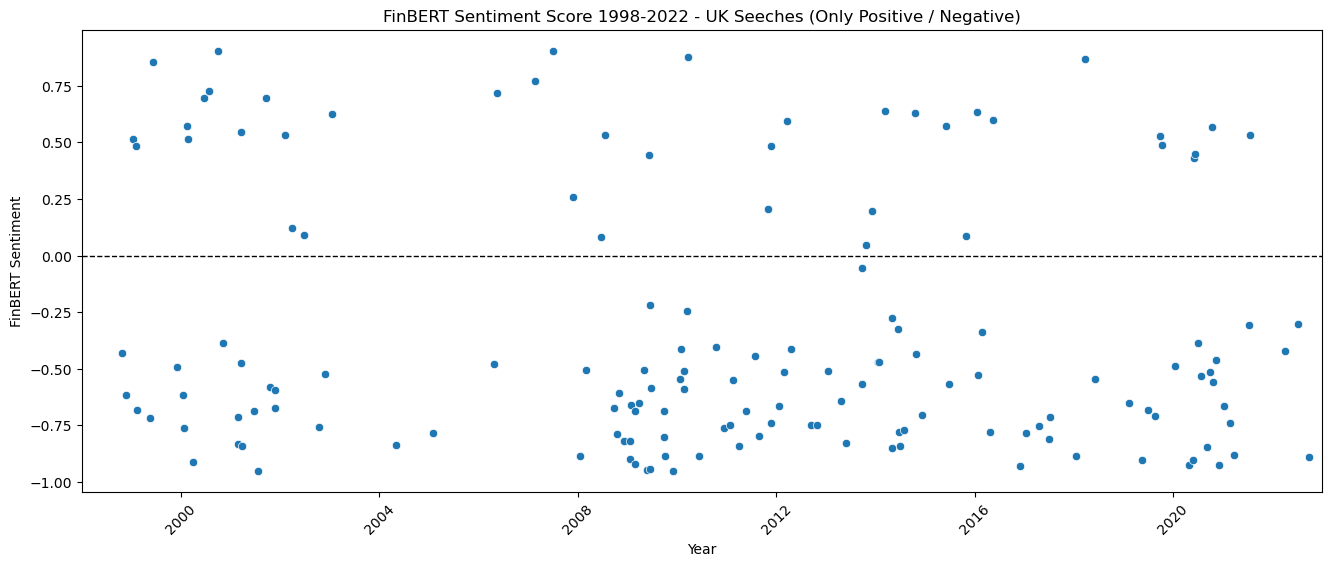

In [49]:
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=pos_neg_bert_uk, x='date', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# X-Axis Limit
ax.set_xlim([pd.Timestamp('1998-01-01'), pd.Timestamp('2022-12-31')])

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('FinBERT Sentiment Score 1998-2022 - UK Seeches (Only Positive / Negative)')

# Display the plot
plt.show()

In [50]:
# Group by 'year' and 'sentiment' and count the number of speeches
sentiment_counts_bert = pos_neg_bert_uk.groupby(['year', 'finbert_sentiment']).size().unstack(fill_value=0)

# Calculate the difference
sentiment_counts_bert['net_difference'] = sentiment_counts_bert['positive'] - sentiment_counts_bert['negative']

# Reset the index to convert the grouped result back to a DataFrame
sentiment_counts_bert = sentiment_counts_bert.reset_index()

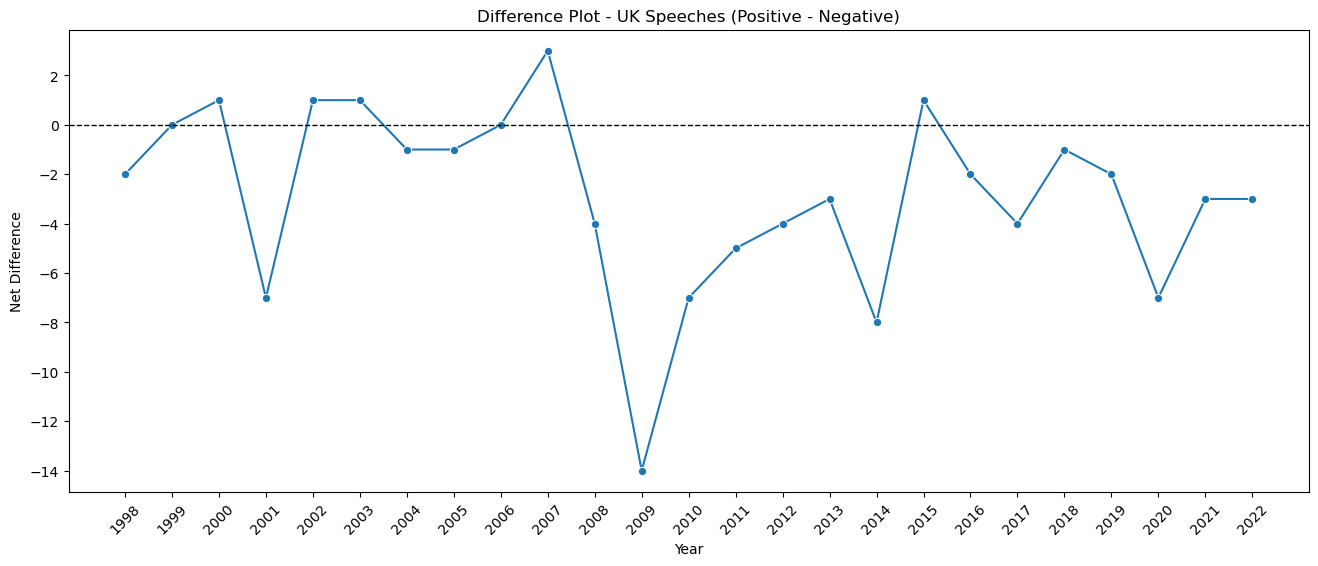

In [51]:
from matplotlib.ticker import MaxNLocator

# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=sentiment_counts_bert, x='year', y='net_difference', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set the x-ticks
years = bert_sentiment_uk['year'].unique()
plt.xticks(ticks=years, rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('Net Difference')

# Set y-axis ticks to be whole numbers
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Set title
plt.title('Difference Plot - UK Speeches (Positive - Negative)')

# Display the plot
plt.show()

In [52]:
# Create DataFrame over all that are not totally 'Neutral'
not_neu_uk = bert_sentiment_uk[bert_sentiment_uk['team_sentiment'] != 'neutral']

# View
not_neu_uk.head(2)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,team_sentiment
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09-01,Tuesday,1998,Speech,george,0,13731,thank you chairman im actually very pleased to...,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",0.087535,0.325207,0.587258,neutral,-0.237672,neutral-negative
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Britain in Europe,george,0,24263,its a great pleasure to be here in the beautif...,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",0.212209,0.017505,0.770286,neutral,0.194704,neutral-positive


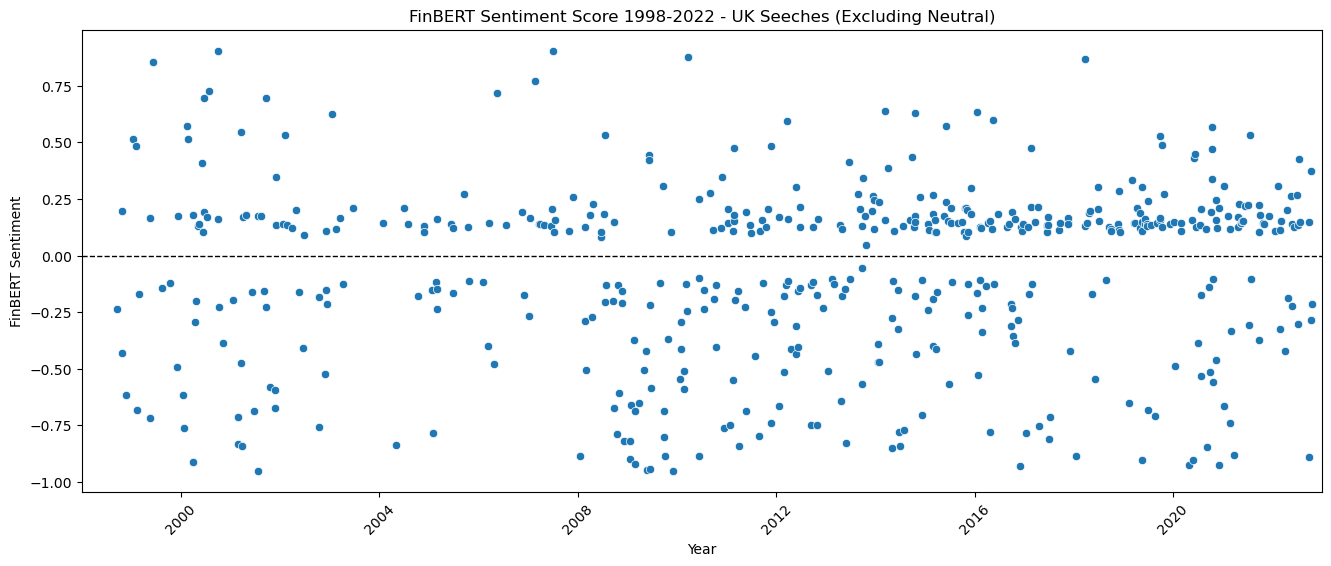

In [53]:
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=not_neu_uk, x='date', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# X-Axis Limit
ax.set_xlim([pd.Timestamp('1998-01-01'), pd.Timestamp('2022-12-31')])

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('FinBERT Sentiment Score 1998-2022 - UK Seeches (Excluding Neutral)')

# Display the plot
plt.show()

In [54]:
# Group by 'year' and 'sentiment' and count the number of speeches
sent_cnts_brt = not_neu_uk.groupby(['year', 'team_sentiment']).size().unstack(fill_value=0)

# Calculate the difference
sent_cnts_brt['net_difference'] = (sent_cnts_brt['positive'] + sent_cnts_brt['neutral-positive']) - \
(sent_cnts_brt['negative'] + sent_cnts_brt['neutral-negative'])

# Reset the index to convert the grouped result back to a DataFrame
sent_cnts_brt = sent_cnts_brt.reset_index()

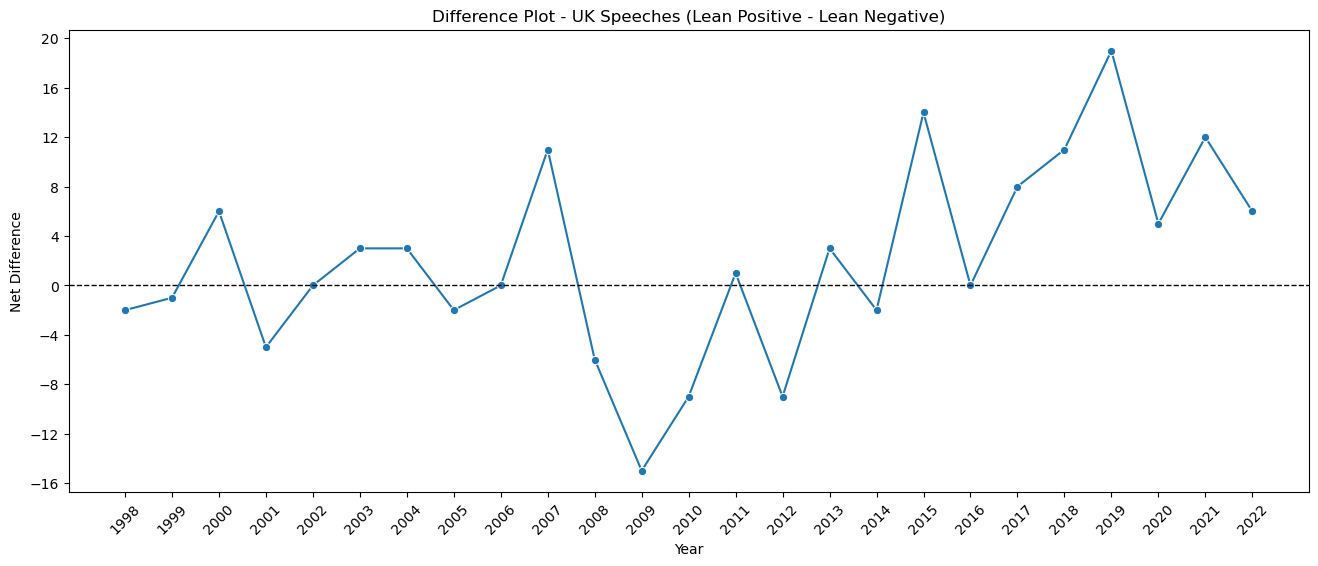

In [55]:
from matplotlib.ticker import MaxNLocator

# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=sent_cnts_brt, x='year', y='net_difference', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set the x-ticks
years = bert_sentiment_uk['year'].unique()
plt.xticks(ticks=years, rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('Net Difference')

# Set y-axis ticks to be whole numbers
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Set title
plt.title('Difference Plot - UK Speeches (Lean Positive - Lean Negative)')

# Display the plot
plt.show()

### CPI & Interest Rates

In [56]:
cpi_rate = pd.read_excel('consumerpriceinflationdetailedreferencetables.xlsx',sheet_name= '6a')

In [57]:
cpi_rate

,Unnamed: 0,Annual average,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2005,79.4,78.3,78.5,78.8,79.1,79.4,79.4,79.5,79.7,79.9,80,80,80.3
1,2006,81.4,80.0,80.2,80.4,80.9,81.3,81.5,81.5,81.8,81.9,82,82.2,82.6
2,2007,83.3,82.1,82.4,82.8,83.1,83.3,83.5,83.1,83.4,83.5,83.8,84.1,84.5
3,2008,86.2,84.1,84.6,84.9,85.6,86.1,86.6,86.6,87.1,87.5,87.3,87.3,87.1
4,2009,87.9,86.6,87.2,87.3,87.5,87.9,88.1,88.0,88.3,88.3,88.4,88.6,88.9
5,2010,90.1,88.8,89.0,89.4,89.9,90.1,90.2,90.0,90.4,90.4,90.6,90.9,91.7
6,2011,93.6,91.8,92.3,92.6,93.3,93.5,93.5,93.5,93.9,94.5,94.5,94.7,95
7,2012,96,94.7,95.2,95.4,95.9,95.9,95.6,95.7,96.1,96.4,96.8,97,97.3
8,2013,98.2,97.0,97.5,97.8,98.0,98.2,98.0,98.0,98.4,98.7,98.8,98.8,99.2
9,2014,99.6,98.7,99.1,99.3,99.6,99.6,99.8,99.6,99.9,100,100.1,99.9,99.9


In [58]:
cpi_rate.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)

In [59]:
cpi_rate.head()

,Year,Annual average,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2005,79.4,78.3,78.5,78.8,79.1,79.4,79.4,79.5,79.7,79.9,80,80,80.3
1,2006,81.4,80.0,80.2,80.4,80.9,81.3,81.5,81.5,81.8,81.9,82,82.2,82.6
2,2007,83.3,82.1,82.4,82.8,83.1,83.3,83.5,83.1,83.4,83.5,83.8,84.1,84.5
3,2008,86.2,84.1,84.6,84.9,85.6,86.1,86.6,86.6,87.1,87.5,87.3,87.3,87.1
4,2009,87.9,86.6,87.2,87.3,87.5,87.9,88.1,88.0,88.3,88.3,88.4,88.6,88.9


In [60]:
#Melt the df to have each month as a new row
df_melted = pd.melt(cpi_rate, 
                    id_vars=['Year'],  # Keep 'year' as identifier
                    value_vars=[' Jan', ' Feb', ' Mar', ' Apr', ' May', ' Jun', ' Jul', ' Aug', ' Sep', ' Oct', ' Nov', ' Dec'],  
                    var_name='Month',  # New column for months
                    value_name='CPI')  # New column for CPI values

month_order = [' Jan', ' Feb', ' Mar', ' Apr', ' May', ' Jun', ' Jul', ' Aug', ' Sep', ' Oct', ' Nov', ' Dec']

# Convert 'Month' column to a categorical type with the correct month order
df_melted['Month'] = pd.Categorical(df_melted['Month'], categories=month_order, ordered=True)

# Sort by 'year' and 'Month' to get the correct sequence
df_melted = df_melted.sort_values(by=['Year', 'Month']).reset_index(drop=True)

In [61]:
cpi_monthly = df_melted

In [62]:
cpi_monthly

,Year,Month,CPI
0,2005,Jan,78.3
1,2005,Feb,78.5
2,2005,Mar,78.8
3,2005,Apr,79.1
4,2005,May,79.4
...,...,...,...
235,2024,Aug,133.4
236,2024,Sep,..
237,2024,Oct,..
238,2024,Nov,..


In [63]:
# Snipping the df to exclude unknown data entries
cpi_monthly = cpi_monthly.head(236)

In [64]:
cpi_monthly['Month'] = cpi_monthly['Month'].str.strip()

In [65]:
cpi_monthly['YearMonth'] = pd.to_datetime(cpi_monthly['Year'].astype(str) + '-' + cpi_monthly['Month'].astype(str) + '-01', format='%Y-%b-%d')

# Format the YearMonth column to 'MMM YYYY'
cpi_monthly['YearMonth'] = cpi_monthly['YearMonth'].dt.strftime('%b %Y')

# Drop the original 'year' and 'Month' columns
cpi_monthly.drop(['Year','Month'], axis=1, inplace=True)


In [66]:
cpi_monthly.rename(columns={'YearMonth':'Date'})

,CPI,Date
0,78.3,Jan 2005
1,78.5,Feb 2005
2,78.8,Mar 2005
3,79.1,Apr 2005
4,79.4,May 2005
...,...,...
231,132.2,Apr 2024
232,132.7,May 2024
233,133.0,Jun 2024
234,132.9,Jul 2024


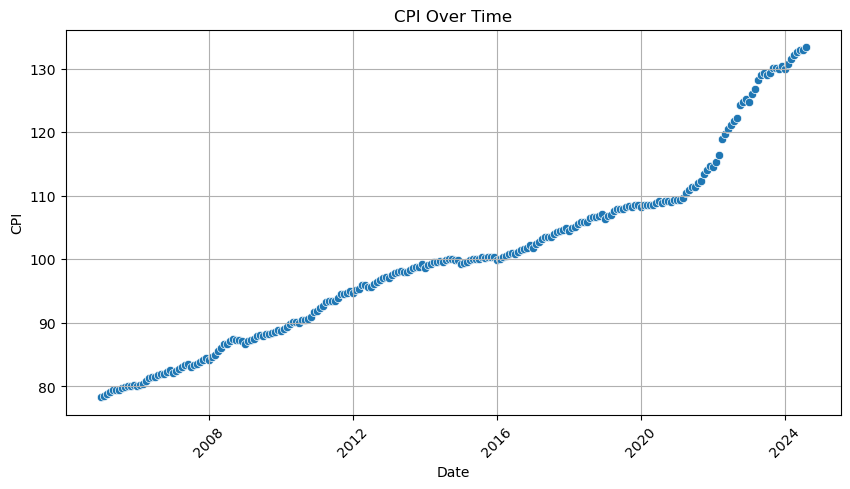

In [67]:
# Plot CPI over time

cpi_monthly['YearMonth'] = pd.to_datetime(cpi_monthly['YearMonth'])
plt.figure(figsize=(10, 5))
sns.scatterplot(data=cpi_monthly, x='YearMonth', y='CPI', marker='o')
plt.title('CPI Over Time')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.grid()
plt.xticks(rotation=45)  
plt.show()

In [68]:
cpi_change = pd.read_excel('consumerpriceinflationdetailedreferencetables.xlsx',sheet_name= '6b')

In [69]:
cpi_change = cpi_change.rename(columns={'Unnamed: 0': 'Year'})

In [70]:
cpi_change[' change'] = pd.to_numeric(cpi_change[' change'], errors='coerce')

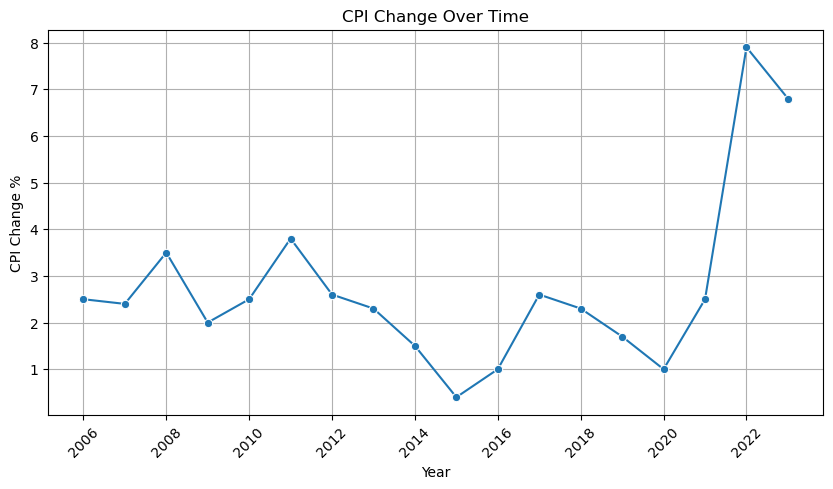

In [71]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Create the line plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=cpi_change, x='Year', y=' change', marker='o')
plt.title('CPI Change Over Time')
plt.xlabel('Year')
plt.ylabel('CPI Change %')
plt.grid()

# Set the x-axis to have 10 ticks
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=10))

plt.xticks(rotation=45)
plt.show()

As mentioned previously, the CPI rate is a continuous measure. It is clear from this graph that in all instances since the first data point, that the CPI has increased year on year, with the lowest % increase from the prior year ocurring in 2014, being just under half a percent. Again, the spike around 2021-2022 is obvious, with the % change reaching 8% increase in 2022, and continuing to remain high in 2023 (7% increase from 2022).

In [72]:
interest = pd.read_excel('Bank Rate_ONS Data.xlsx', sheet_name = 'rates')

In [73]:
interest['% Rate'] = interest['% Rate'] *100

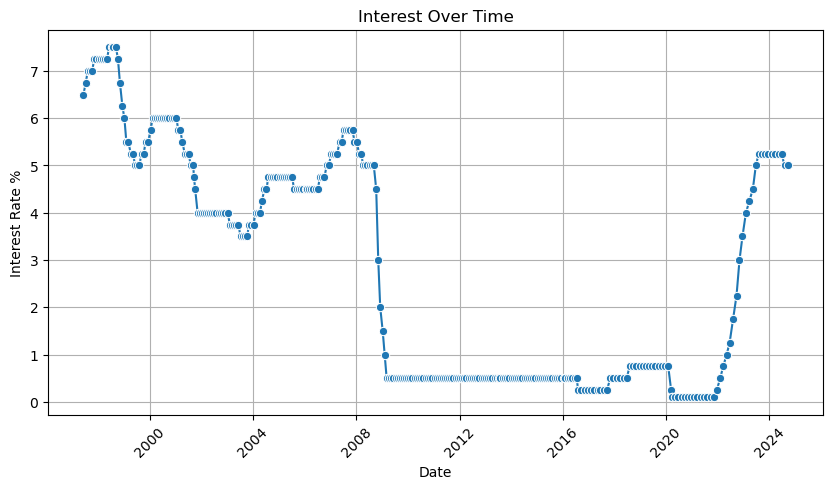

In [74]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=interest, x='Date', y='% Rate', marker='o')
plt.title('Interest Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate %')
plt.grid()

plt.xticks(rotation=45)
plt.show()

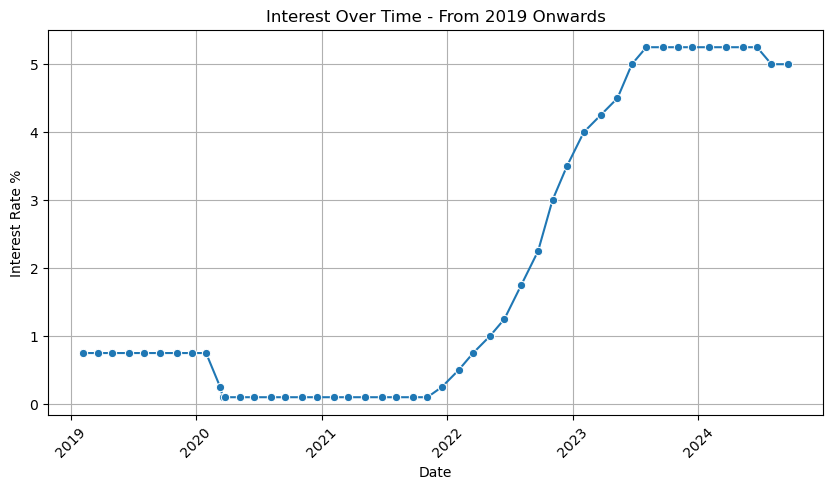

In [75]:
filtered_interest = interest[interest['Date'] >= '2019-01-01']

# Plot the filtered data
plt.figure(figsize=(10, 5))
sns.lineplot(data=filtered_interest, x='Date', y='% Rate', marker='o')
plt.title('Interest Over Time - From 2019 Onwards')
plt.xlabel('Date')
plt.ylabel('Interest Rate %')
plt.grid()

plt.xticks(rotation=45)
plt.show()

### Analysis for Presentation- Interest Rates

After some trial and error, quarterly mapping of interest rates/ CPI rates yielded results of limited use, especially when mapping a correlation coefficient score. Hence, monthly data will be analysed below

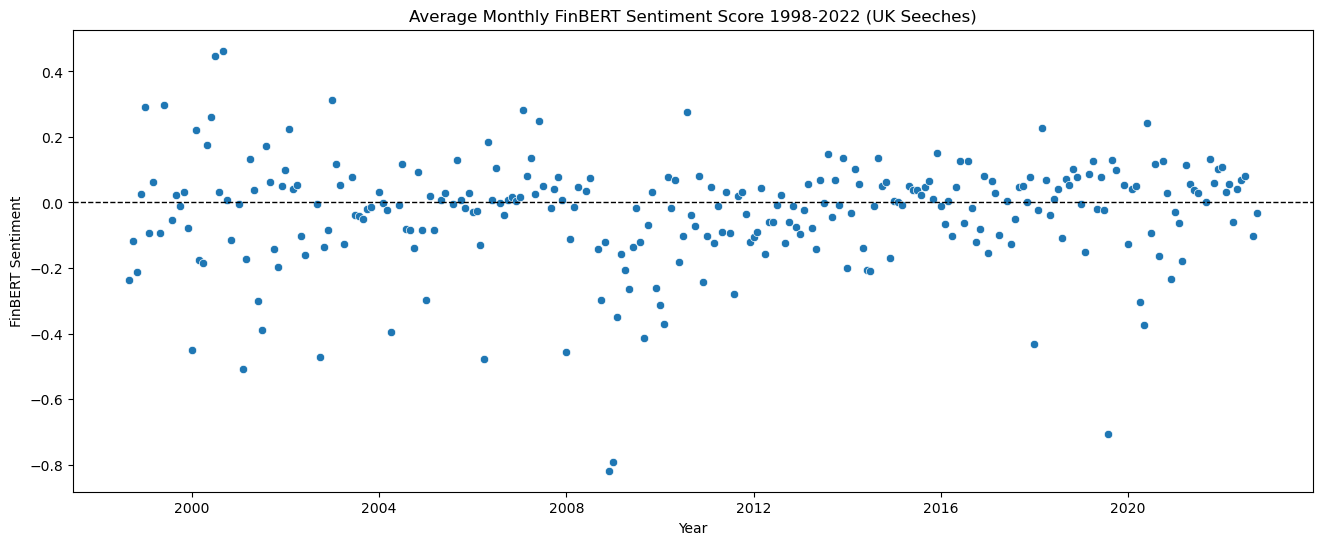

In [76]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=avg_bert, x='year_month', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Monthly FinBERT Sentiment Score 1998-2022 (UK Seeches)')

# Display the plot
plt.show()

In [77]:
avg_bert

,finbert_score
year_month,
1998-09-01,-0.237672
1998-10-01,-0.116984
1998-11-01,-0.211394
1998-12-01,0.026567
1999-01-01,0.292472
...,...
2022-05-01,0.039841
2022-06-01,0.067949
2022-07-01,0.079329


In [78]:
interest['Date'] = pd.to_datetime(interest['Date'])

# Convert dates to the first day of the month
interest['Date'] = interest['Date'].dt.to_period('M').dt.to_timestamp()

# Sort the DataFrame by Date to ensure proper calculation
interest.sort_values(by='Date', inplace=True)

# Calculate the month-to-month percentage change and add it as a new column
interest['% Rate Change'] = interest['% Rate'].diff()  # Multiply by 100 for percentage

# Display the updated DataFrame with the new column
print(interest)


          Date  % Rate  % Rate Change
0   1997-06-01    6.50            NaN
1   1997-07-01    6.75           0.25
2   1997-08-01    7.00           0.25
3   1997-09-01    7.00           0.00
4   1997-10-01    7.00           0.00
..         ...     ...            ...
294 2024-03-01    5.25           0.00
295 2024-05-01    5.25           0.00
296 2024-06-01    5.25           0.00
297 2024-08-01    5.00          -0.25
298 2024-09-01    5.00           0.00

[299 rows x 3 columns]


In [79]:
interest_matched = interest[interest['Date'] >= '1998-09-01']

In [80]:
interest_matched

,Date,% Rate,% Rate Change
15,1998-09-01,7.50,0.00
16,1998-10-01,7.25,-0.25
17,1998-11-01,6.75,-0.50
18,1998-12-01,6.25,-0.50
19,1999-01-01,6.00,-0.25
...,...,...,...
294,2024-03-01,5.25,0.00
295,2024-05-01,5.25,0.00
296,2024-06-01,5.25,0.00
297,2024-08-01,5.00,-0.25


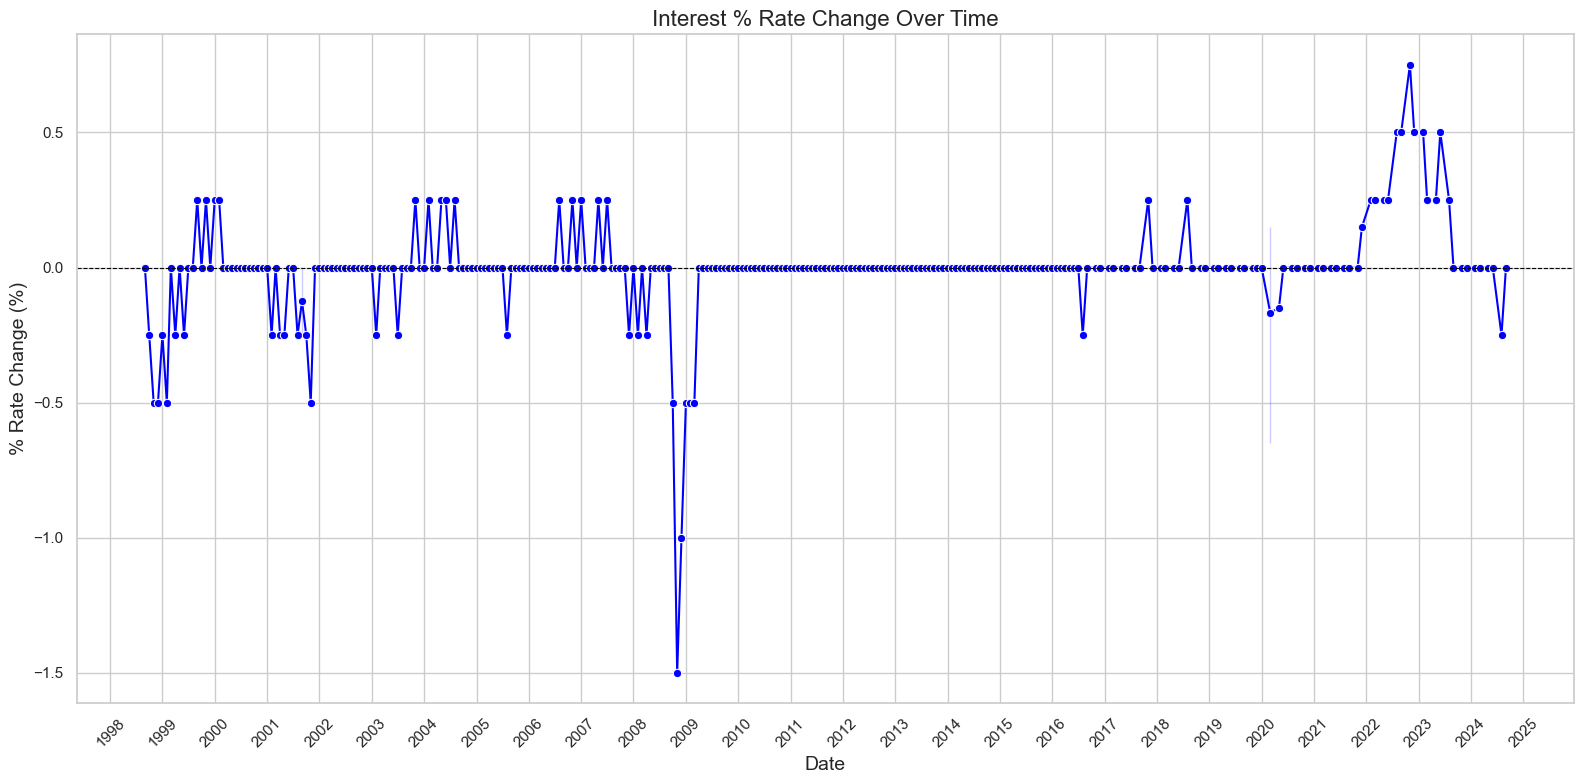

In [81]:
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(16, 8))
sns.lineplot(data=interest_matched, x='Date', y='% Rate Change', marker='o', color='blue')

# Adding titles and labels
plt.title('Interest % Rate Change Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('% Rate Change (%)', fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) 

# Set x-axis to show every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()

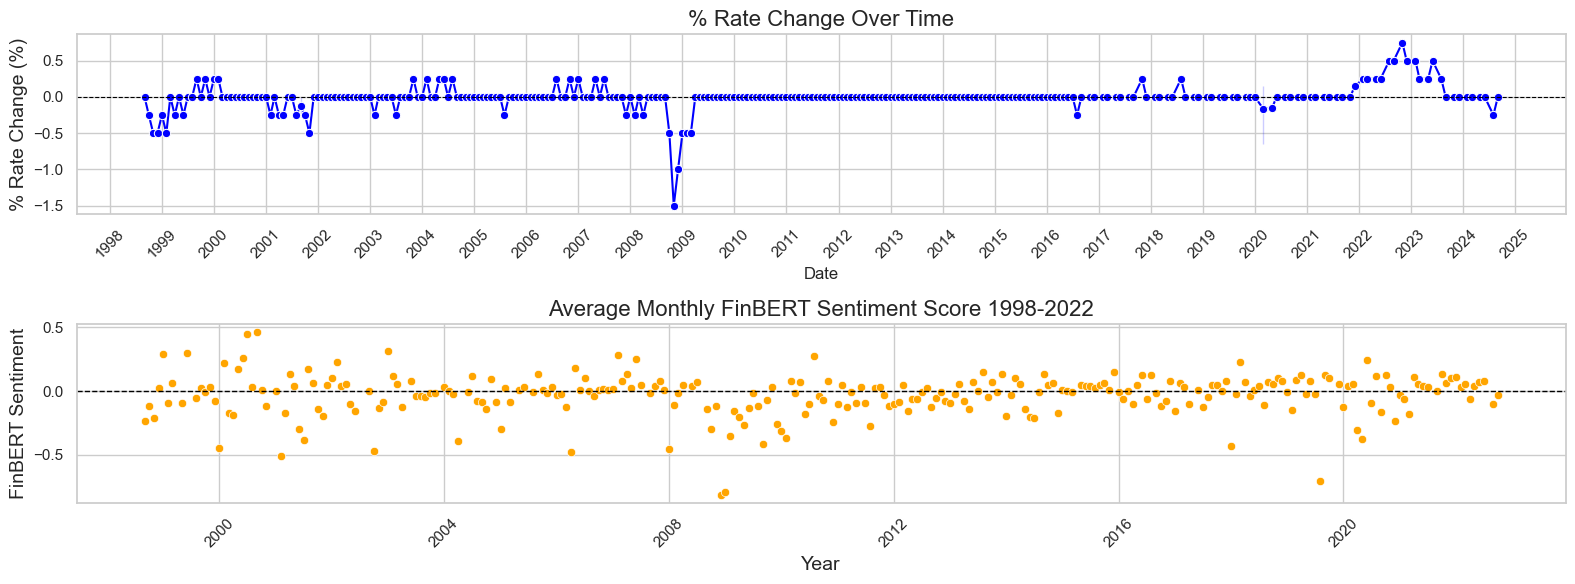

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Create the figure
plt.figure(figsize=(16, 6))

# Plotting the % Rate Change
# First Axes for % Rate Change
ax1 = plt.subplot(2, 1, 1)  
sns.lineplot(data=interest_matched, x='Date', y='% Rate Change', marker='o', ax=ax1, color='blue')
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)  
ax1.set_title('% Rate Change Over Time', fontsize=16)
ax1.set_ylabel('% Rate Change (%)', fontsize=14)
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Second Axes for FinBERT Sentiment
ax2 = plt.subplot(2, 1, 2) 
sns.scatterplot(data=avg_bert, x='year_month', y='finbert_score', marker='o', ax=ax2, color='orange')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_title('Average Monthly FinBERT Sentiment Score 1998-2022', fontsize=16)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel('FinBERT Sentiment', fontsize=14)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


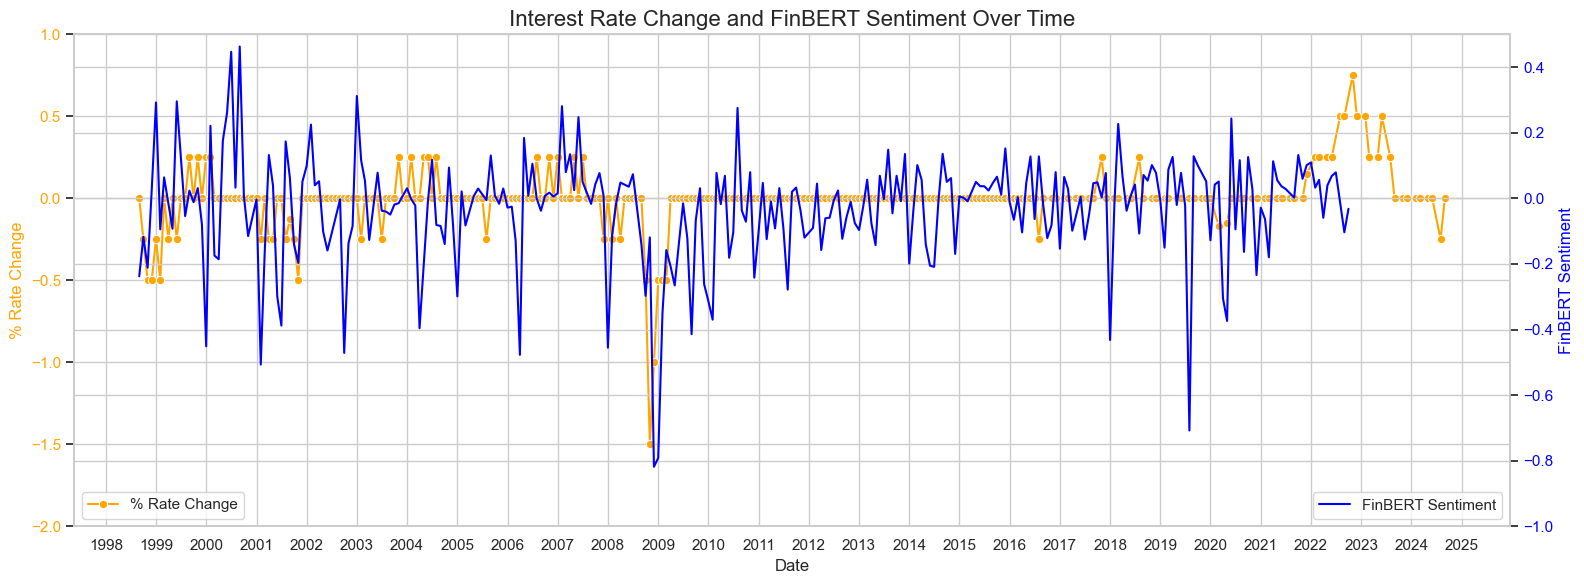

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Create the figure
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plotting the % Rate Change on the left y-axis
sns.lineplot(data=interest_matched, x='Date', y='% Rate Change', marker='o', color='orange', ax=ax1, label='% Rate Change')
ax1.set_ylabel('% Rate Change', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Manually set y-axis limits for % Rate Change
ax1.set_ylim(-2, 1) 

# Create a secondary y-axis for FinBERT Sentiment
ax2 = ax1.twinx() 
sns.lineplot(data=avg_bert, x='year_month', y='finbert_score', color='blue', ax=ax2, label='FinBERT Sentiment')
ax2.set_ylabel('FinBERT Sentiment', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Manually set y-axis limits for FinBERT Sentiment
ax2.set_ylim(-1, 0.5) 

# Set titles and labels
plt.title('Interest Rate Change and FinBERT Sentiment Over Time', fontsize=16)

# Format x-axis to show every year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)

# Display the legends at the bottom left and bottom right
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()



In [84]:
decision = pd.read_excel('bank_rate_decisions.xlsx', sheet_name='mean_avg')

In [85]:
decision = decision.rename(columns={'average':'voted average % rate'})

In [86]:
decision['Date'] = pd.to_datetime(decision['Date'])

# Convert dates to the first day of the month
decision['Date'] = decision['Date'].dt.to_period('M').dt.to_timestamp()

# Sort the DataFrame by Date to ensure proper calculation
decision.sort_values(by='Date', inplace=True)

# Calculate the month-to-month percentage change and add it as a new column
decision['% Rate Change'] = decision['voted average % rate'].diff()*100 

# Display the updated DataFrame with the new column
print(decision)


          Date  voted average % rate  % Rate Change
0   1997-06-01              0.065000            NaN
1   1997-07-01              0.067500       0.250000
2   1997-08-01              0.070000       0.250000
3   1997-09-01              0.070000       0.000000
4   1997-10-01              0.070000       0.000000
..         ...                   ...            ...
294 2024-03-01              0.052222      -0.055556
295 2024-05-01              0.051944      -0.027778
296 2024-06-01              0.051944       0.000000
297 2024-08-01              0.051111      -0.083333
298 2024-09-01              0.049722      -0.138889

[299 rows x 3 columns]


In [87]:
decision_matched = decision[decision['Date'] >= '1998-09-01']

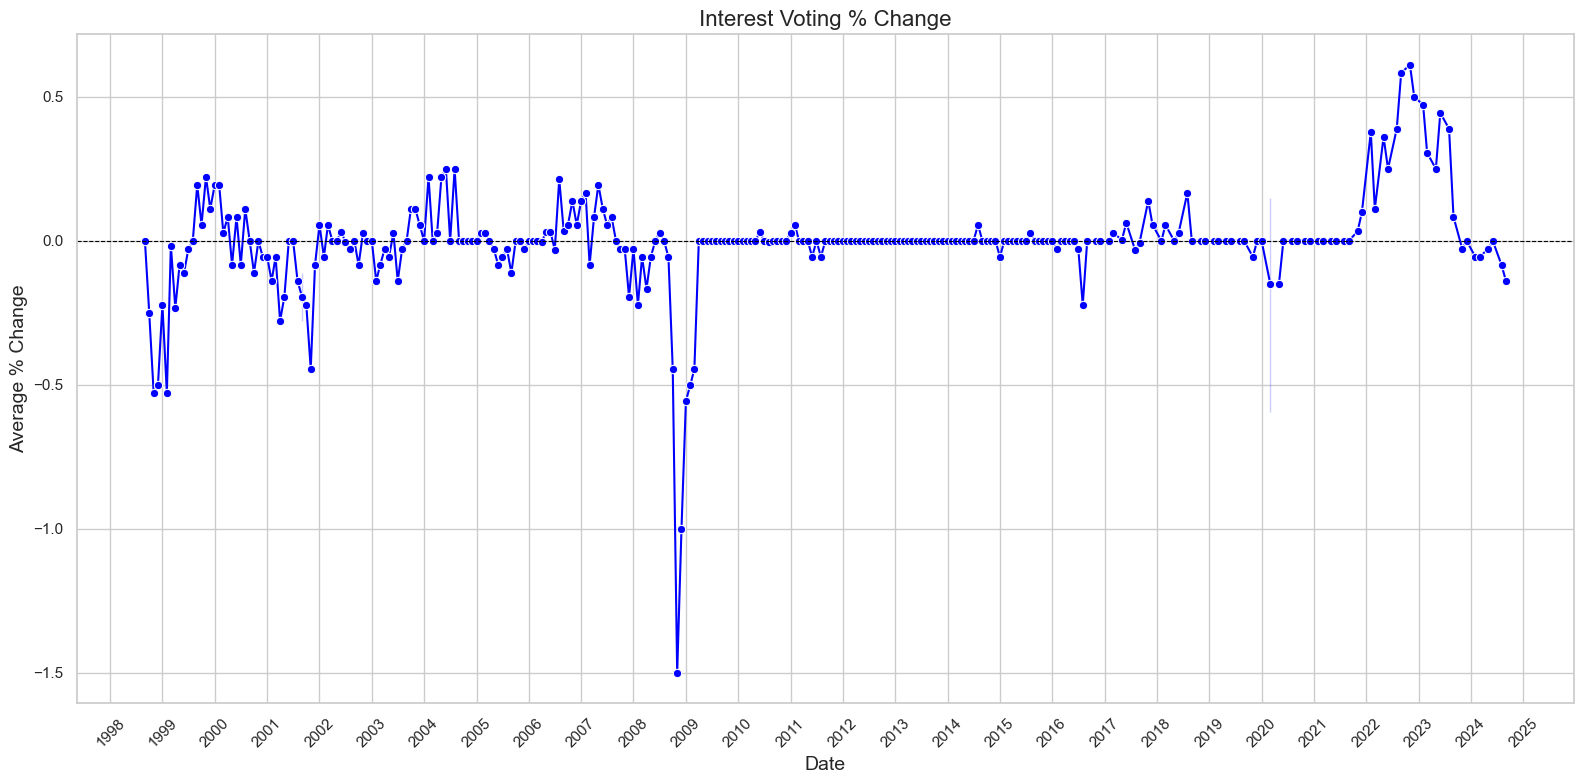

In [88]:
sns.set(style='whitegrid')

# Create the plot
plt.figure(figsize=(16, 8))
sns.lineplot(data=decision_matched, x='Date', y='% Rate Change', marker='o', color='blue')

# Adding titles and labels
plt.title('Interest Voting % Change', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average % Change', fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  

# Set x-axis to show every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

plt.xticks(rotation=45) 

# Show the plot
plt.tight_layout() 
plt.show()

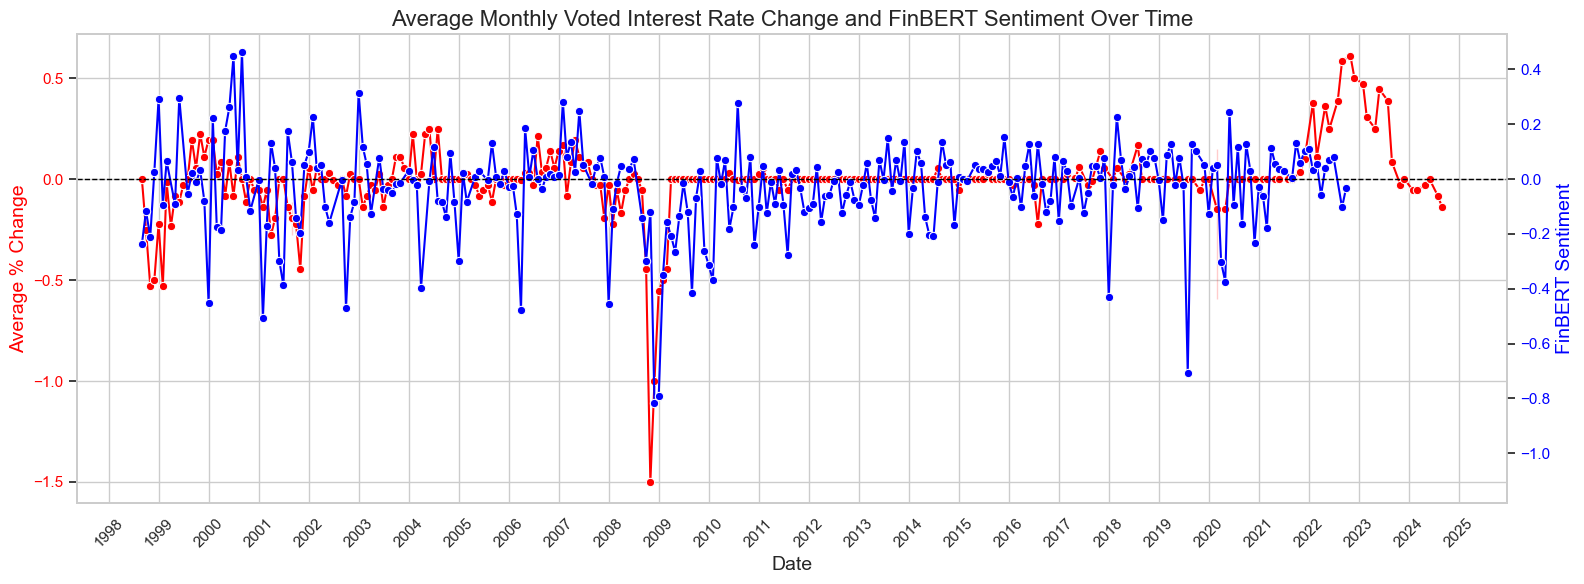

In [89]:
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

# Create the figure and the first axis for voted average interest rate
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot the first line (voted average interest rate)
sns.lineplot(data=decision_matched, x='Date', y='% Rate Change', marker='o', color='red', ax=ax1)
ax1.set_title('Average Monthly Voted Interest Rate Change and FinBERT Sentiment Over Time', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Average % Change', fontsize=14, color='red')
ax1.tick_params(axis='y', labelcolor='red')


# Set x-axis to show every year
ax1.xaxis.set_major_locator(mdates.YearLocator(1))  
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.xticks(rotation=45)

# Create a twin y-axis to plot FinBERT Sentiment
ax2 = ax1.twinx()
sns.lineplot(data=avg_bert, x='year_month', y='finbert_score', marker='o', color='blue', ax=ax2)
ax2.set_ylabel('FinBERT Sentiment', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)

# Adjust the sentiment axis to shift it up slightly
y2_min, y2_max = ax2.get_ylim()

# Increase the lower limit to shift the axis upwards
ax2.set_ylim(y2_min - 0.3, y2_max)

# Disable grid on the secondary axis to prevent misaligned gridlines
ax2.grid(visible=False)

# Tight layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()


In [90]:
from scipy.stats import pearsonr

decision_merged2 = decision_matched.merge(avg_bert, left_on='Date', right_on='year_month')

# Extract the two columns of interest from decision_merged
x = decision_merged2['% Rate Change']
y = decision_merged2['finbert_score']

# Calculate Pearson correlation and p-value
correlation, p_value = pearsonr(x, y)

# Print the results
print(f"Pearson Correlation Coefficient: {correlation:.5f}")
print(f"P-Value: {p_value:.5f}")

Pearson Correlation Coefficient: 0.25058
P-Value: 0.00006


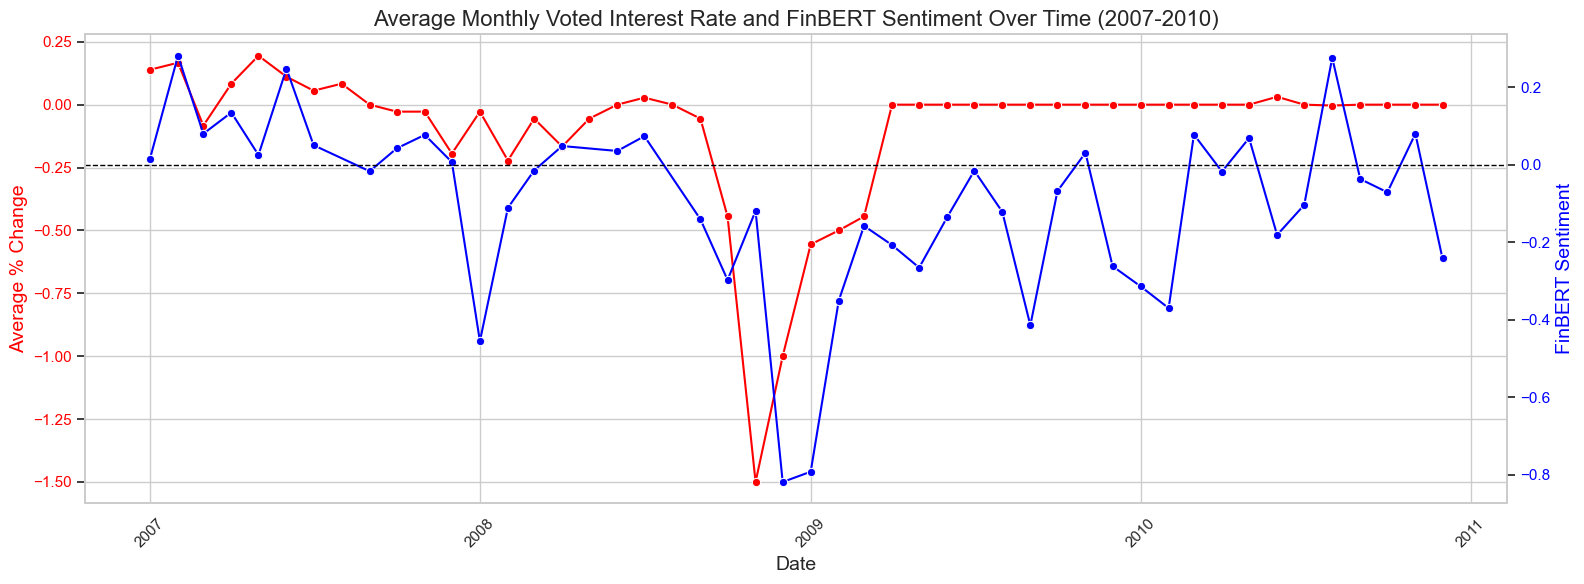

In [91]:
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data to only include dates from 2008-01-01 to 2010-12-31
start_date = '2007-01-01'
end_date = '2010-12-31'

# Filter 'decision_matched' based on the date range
decision_matched['Date'] = pd.to_datetime(decision_matched['Date'])
decision_matched = decision_matched[(decision_matched['Date'] >= start_date) & (decision_matched['Date'] <= end_date)]

# Filter 'avg_bert' based on the same date range
avg_bert = avg_bert[(avg_bert.index >= start_date) & (avg_bert.index <= end_date)]

# Create the figure and the first axis for voted average interest rate
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot the first line (voted average interest rate)
sns.lineplot(data=decision_matched, x='Date', y='% Rate Change', marker='o', color='red', ax=ax1)
ax1.set_title('Average Monthly Voted Interest Rate and FinBERT Sentiment Over Time (2007-2010)', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Average % Change', fontsize=14, color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Set x-axis to show every year
ax1.xaxis.set_major_locator(mdates.YearLocator(1)) 
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.xticks(rotation=45)

# Create a twin y-axis to plot FinBERT Sentiment
ax2 = ax1.twinx()

# Plot FinBERT Sentiment using the 'year_month' index for 'avg_bert'
sns.lineplot(data=avg_bert, x=avg_bert.index, y='finbert_score', marker='o', color='blue', ax=ax2)
ax2.set_ylabel('FinBERT Sentiment', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)

# Adjust the sentiment axis to shift it up slightly
y2_min, y2_max = ax2.get_ylim()

# Disable grid on the secondary axis to prevent misaligned gridlines
ax2.grid(visible=False)

# Tight layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()


In [92]:
# Filter both datasets for the date range from 2007-01-01 to 2010-12-31
start_date = '2007-01-01'
end_date = '2010-12-31'

# Filter 'decision_matched' based on the date range
decision_matched['Date'] = pd.to_datetime(decision_matched['Date'])
decision_matched_filtered = decision_matched[(decision_matched['Date'] >= start_date) & (decision_matched['Date'] <= end_date)]

# Filter 'avg_bert' based on the same date range
avg_bert_filtered = avg_bert[(avg_bert.index >= start_date) & (avg_bert.index <= end_date)]

# Ensure the filtered data has the same length and alignment for correlation calculation
merged_data = pd.merge(decision_matched_filtered, avg_bert_filtered, left_on='Date', right_index=True, how='inner')

# Calculate Pearson correlation coefficient and p-value
corr_coefficient, p_value = pearsonr(merged_data['% Rate Change'], merged_data['finbert_score'])

# Print the results
print(f"Pearson correlation coefficient: {corr_coefficient}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: 0.48423377014183744
P-value: 0.0007504749320692279


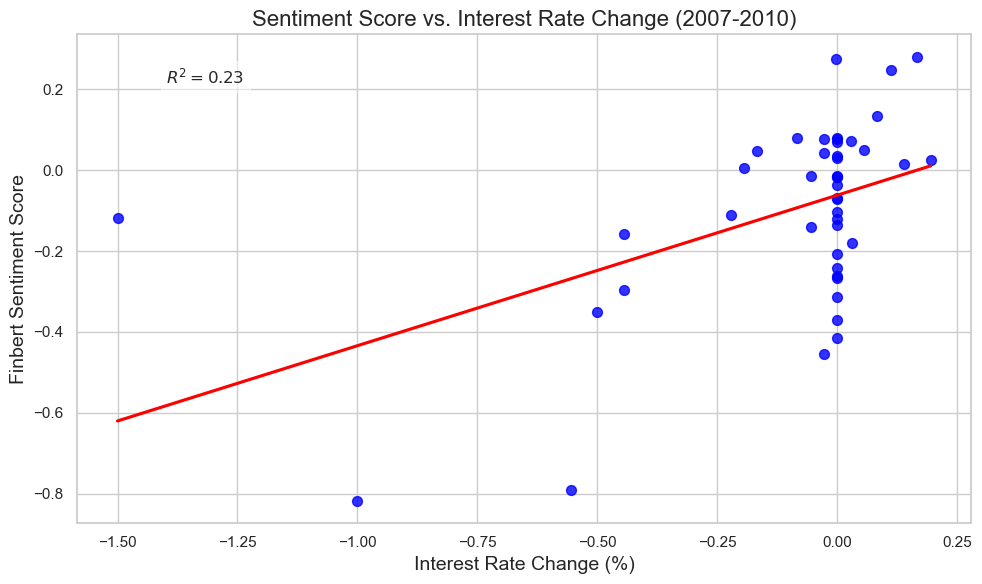

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Ensure that the necessary columns are numeric
merged_data['% Rate Change'] = pd.to_numeric(merged_data['% Rate Change'], errors='coerce')
merged_data['finbert_score'] = pd.to_numeric(merged_data['finbert_score'], errors='coerce')

# Set up the plot
sns.set(style='whitegrid') 
fig, ax = plt.subplots(figsize=(10, 6))

# Scatterplot with regression line using Seaborn
sns.regplot(data=merged_data, x='% Rate Change', y='finbert_score', ax=ax, 
            scatter_kws={'color': 'blue', 's': 50}, 
            line_kws={'color': 'red'}, ci=None)

# Fit Linear Regression Model
X = merged_data['% Rate Change'].values.reshape(-1, 1) 
y = merged_data['finbert_score'].values  
model = LinearRegression().fit(X, y)
r2 = r2_score(y, model.predict(X))

# Display R² on the plot
ax.text(0.1, 0.9, f'$R^2 = {r2:.2f}$', fontsize=12, 
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Set labels and title
ax.set_title('Sentiment Score vs. Interest Rate Change (2007-2010)', fontsize=16)
ax.set_xlabel('Interest Rate Change (%)', fontsize=14)
ax.set_ylabel('Finbert Sentiment Score', fontsize=14)

# Show the plot
plt.tight_layout()  
plt.show()

Correlation not presented well plus low R^2 score so not used in presentation.

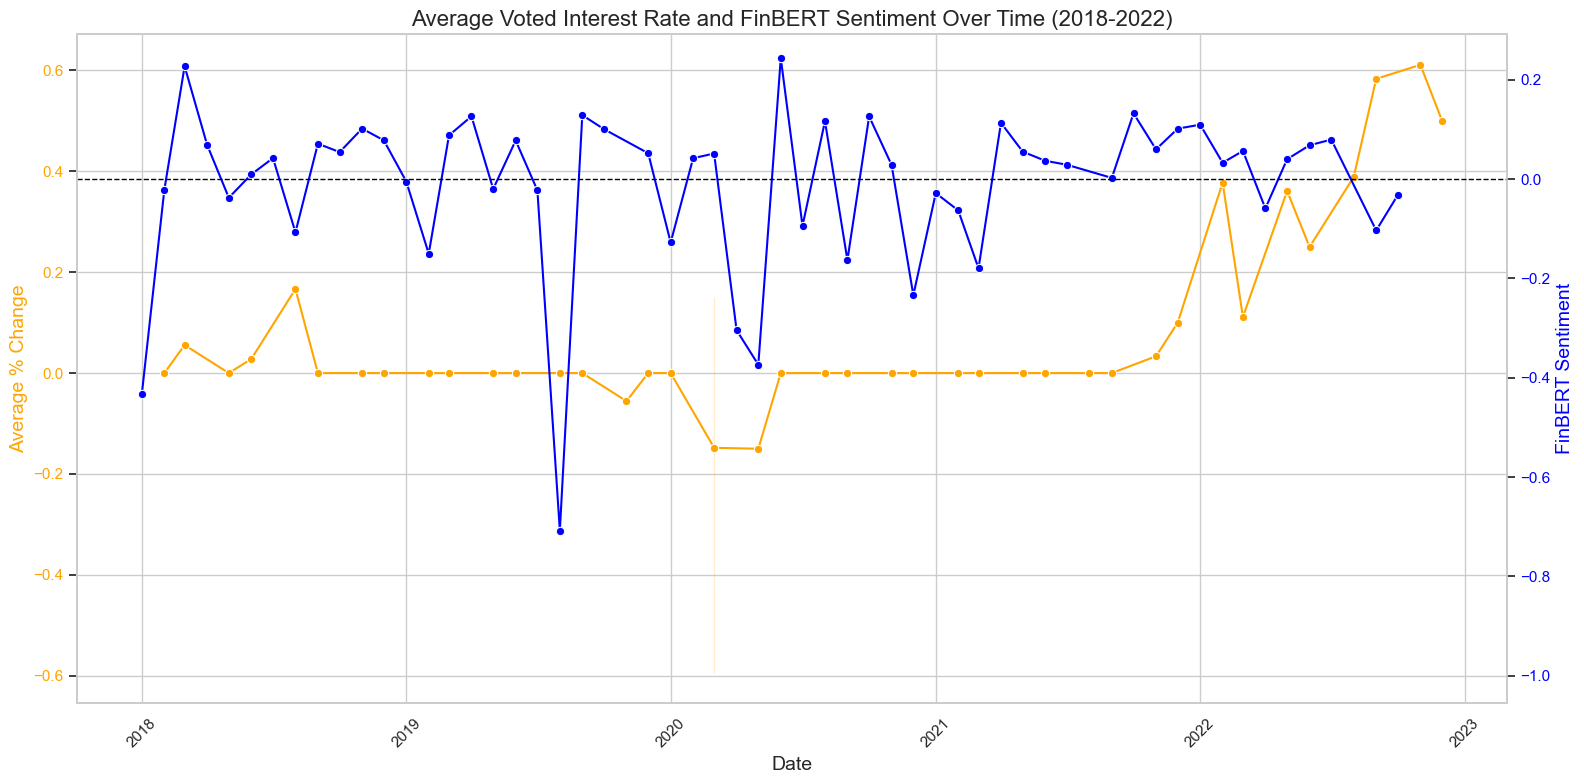

In [94]:
# Reset 'decision_matched' for plotting with new dates
decision_matched = decision[decision['Date'] >= '1998-09-01']

# Reset 'avg_bert' for plotting with new dates.
avg_bert = pd.DataFrame(bert_sentiment_uk.groupby('year_month')['finbert_score'].mean())

# Filter the data to only include dates from 2018-01-01 to 2022-12-31
start_date = '2018-01-01'
end_date = '2022-12-31'

# Filter 'decision_matched' based on the date range
decision_matched['Date'] = pd.to_datetime(decision_matched['Date'])
decision_matched = decision_matched[(decision_matched['Date'] >= start_date) & (decision_matched['Date'] <= end_date)]

# Filter 'avg_bert' based on the same date range
avg_bert = avg_bert[(avg_bert.index >= start_date) & (avg_bert.index <= end_date)]

# Create the figure and the first axis for voted average interest rate
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot the first line (voted average interest rate)
sns.lineplot(data=decision_matched, x='Date', y='% Rate Change', marker='o', color='orange', ax=ax1)
ax1.set_title('Average Voted Interest Rate and FinBERT Sentiment Over Time (2018-2022)', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Average % Change', fontsize=14, color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Set x-axis to show every year
ax1.xaxis.set_major_locator(mdates.YearLocator(1)) 
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.xticks(rotation=45)

# Create a twin y-axis to plot FinBERT Sentiment
ax2 = ax1.twinx()

# Plot FinBERT Sentiment using the 'year_month' index for 'avg_bert'
sns.lineplot(data=avg_bert, x=avg_bert.index, y='finbert_score', marker='o', color='blue', ax=ax2)
ax2.set_ylabel('FinBERT Sentiment', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)

# Adjust the sentiment axis to shift it up slightly
y2_min, y2_max = ax2.get_ylim()

# Increase the lower limit to shift the axis upwards
ax2.set_ylim(y2_min - 0.3, y2_max) 

# Disable grid on the secondary axis to prevent misaligned gridlines
ax2.grid(visible=False)

# Tight layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [95]:
# Filter both datasets for the date range from 2018-01-01 to 2022-12-31
start_date = '2018-01-01'
end_date = '2022-12-31'

# Filter 'decision_matched' based on the date range
decision_matched['Date'] = pd.to_datetime(decision_matched['Date'])
decision_matched_filtered = decision_matched[(decision_matched['Date'] >= start_date) & (decision_matched['Date'] <= end_date)]

# Filter 'avg_bert' based on the same date range
avg_bert_filtered = avg_bert[(avg_bert.index >= start_date) & (avg_bert.index <= end_date)]

# Ensure the filtered data has the same length and alignment for correlation calculation
merged_data = pd.merge(decision_matched_filtered, avg_bert_filtered, left_on='Date', right_index=True, how='inner')

# Calculate Pearson correlation coefficient and p-value
corr_coefficient, p_value = pearsonr(merged_data['% Rate Change'], merged_data['finbert_score'])

# Print the results
print(f"Pearson correlation coefficient: {corr_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.04605315882263358
P-value: 0.7866531575578857


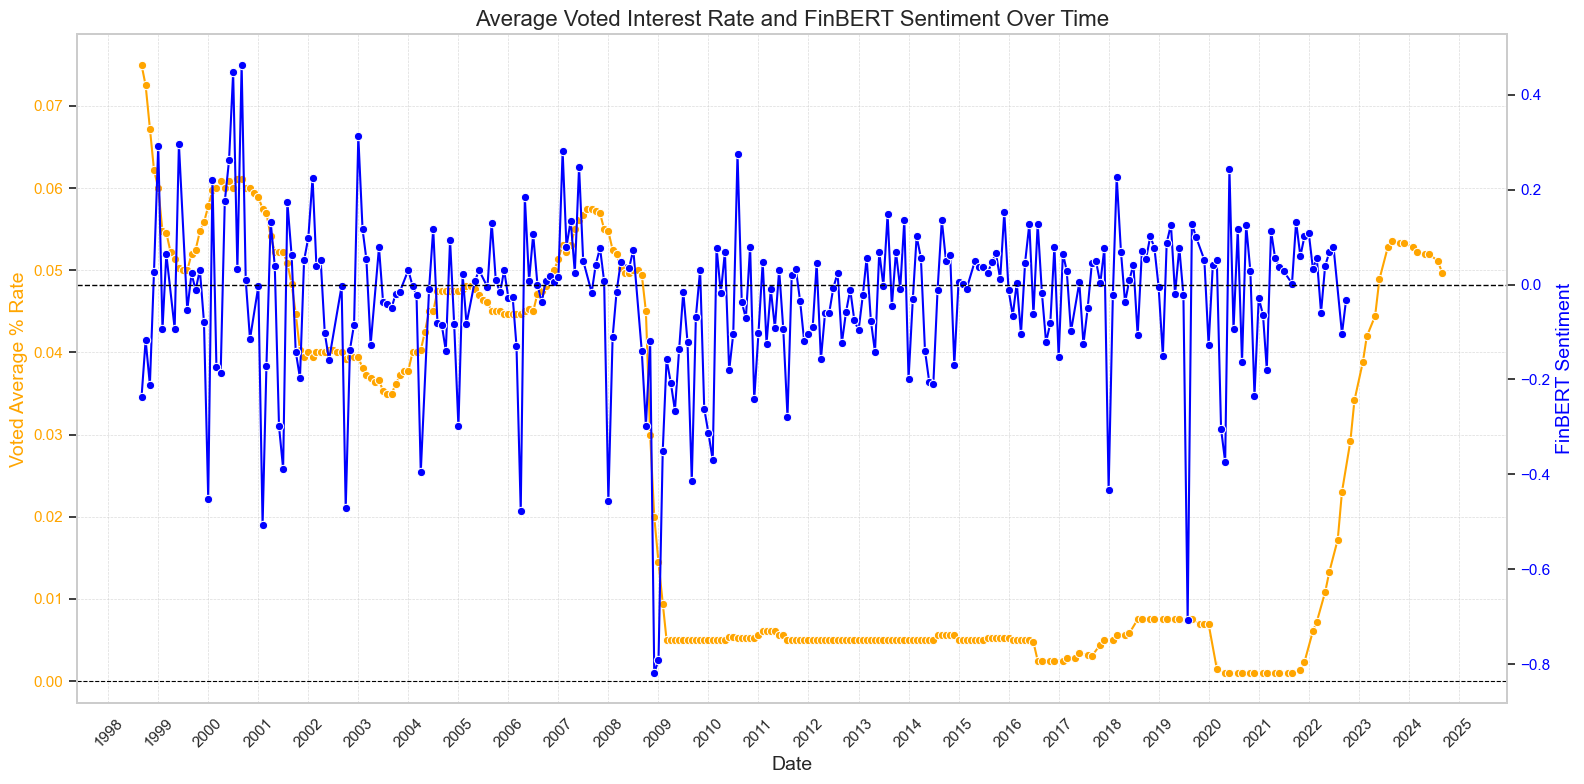

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Reset 'decision_matched' for plotting with new dates
decision_matched = decision[decision['Date'] >= '1998-09-01']

# Reset 'avg_bert' for plotting with new dates.
avg_bert = pd.DataFrame(bert_sentiment_uk.groupby('year_month')['finbert_score'].mean())


# Create the figure and the first axis for voted average interest rate
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot the first line (voted average interest rate)
sns.lineplot(data=decision_matched, x='Date', y='voted average % rate', marker='o', color='orange', ax=ax1)
ax1.set_title('Average Voted Interest Rate and FinBERT Sentiment Over Time', fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Voted Average % Rate', fontsize=14, color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8) 

# Enable grid on the primary axis
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set x-axis to show every year
ax1.xaxis.set_major_locator(mdates.YearLocator(1))  
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.xticks(rotation=45)

# Create a twin y-axis to plot FinBERT Sentiment
ax2 = ax1.twinx()
sns.lineplot(data=avg_bert, x='year_month', y='finbert_score', marker='o', color='blue', ax=ax2)
ax2.set_ylabel('FinBERT Sentiment', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)

# Disable grid on the secondary axis to prevent misaligned gridlines
ax2.grid(visible=False)

# Tight layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()


In [97]:
decision_merged = decision_matched.merge(avg_bert, left_on='Date', right_on='year_month')

# Extract the two columns of interest from decision_merged
x = decision_merged['voted average % rate']
y = decision_merged['finbert_score']

# Calculate Pearson correlation and p-value
correlation, p_value = pearsonr(x, y)

# Print the results
print(f"Pearson Correlation Coefficient: {correlation:.3f}")
print(f"P-Value: {p_value:.3f}")


Pearson Correlation Coefficient: 0.056
P-Value: 0.374


Too high of a P-value with very weak correlation, so not to be used.

### Analysis for Presentation- CPI Rates

In [98]:
cpi_monthly

,CPI,YearMonth
0,78.3,2005-01-01
1,78.5,2005-02-01
2,78.8,2005-03-01
3,79.1,2005-04-01
4,79.4,2005-05-01
...,...,...
231,132.2,2024-04-01
232,132.7,2024-05-01
233,133.0,2024-06-01
234,132.9,2024-07-01


In [99]:
cpi_monthly['YearMonth'] = pd.to_datetime(cpi_monthly['YearMonth'])

# Calculate the month-to-month CPI change
cpi_monthly['CPI Change'] = cpi_monthly['CPI'].diff()

cpi_monthly

,CPI,YearMonth,CPI Change
0,78.3,2005-01-01,NaN
1,78.5,2005-02-01,0.2
2,78.8,2005-03-01,0.3
3,79.1,2005-04-01,0.3
4,79.4,2005-05-01,0.3
...,...,...,...
231,132.2,2024-04-01,0.6
232,132.7,2024-05-01,0.5
233,133.0,2024-06-01,0.3
234,132.9,2024-07-01,-0.1


In [100]:
cpi_monthly= cpi_monthly[cpi_monthly['YearMonth'] >= '2005-02-01']

In [101]:
avg_bert_matched = avg_bert.reset_index()

In [102]:
avg_bert_matched['year_month'] = pd.to_datetime(avg_bert_matched['year_month'])

# Filter the DataFrame to only include rows from '2005-01-01' onwards
avg_bert_matched = avg_bert_matched[avg_bert_matched['year_month'] >= '2005-02-01'].reset_index(drop=True)

# Display the filtered DataFrame
print(avg_bert_matched)

    year_month  finbert_score
0   2005-02-01       0.021269
1   2005-03-01      -0.082656
2   2005-05-01       0.007667
3   2005-06-01       0.029889
4   2005-08-01      -0.005417
..         ...            ...
198 2022-05-01       0.039841
199 2022-06-01       0.067949
200 2022-07-01       0.079329
201 2022-09-01      -0.103491
202 2022-10-01      -0.031868

[203 rows x 2 columns]


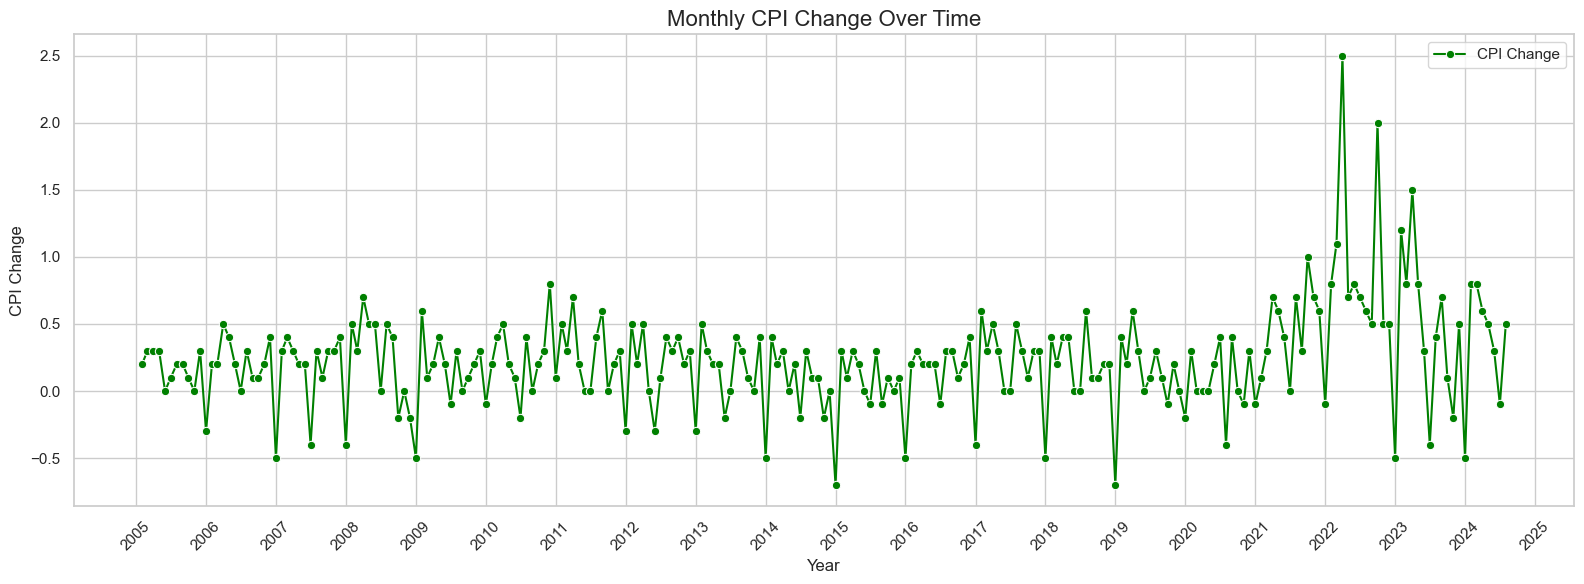

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure the 'YearMonth' column is in datetime format (if not already)
cpi_monthly['YearMonth'] = pd.to_datetime(cpi_monthly['YearMonth'])

# Create the plot
plt.figure(figsize=(16, 6))

# Line plot for CPI Change
sns.lineplot(data=cpi_monthly, x='YearMonth', y='CPI Change', marker='o', color='green', label='CPI Change')

# Adding titles and labels
plt.title('Monthly CPI Change Over Time', fontsize=16)
plt.xlabel('Year')
plt.ylabel('CPI Change')

# Set x-axis to show only the year
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format x-axis to show only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to each year

# Show grid
plt.grid(True)

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()



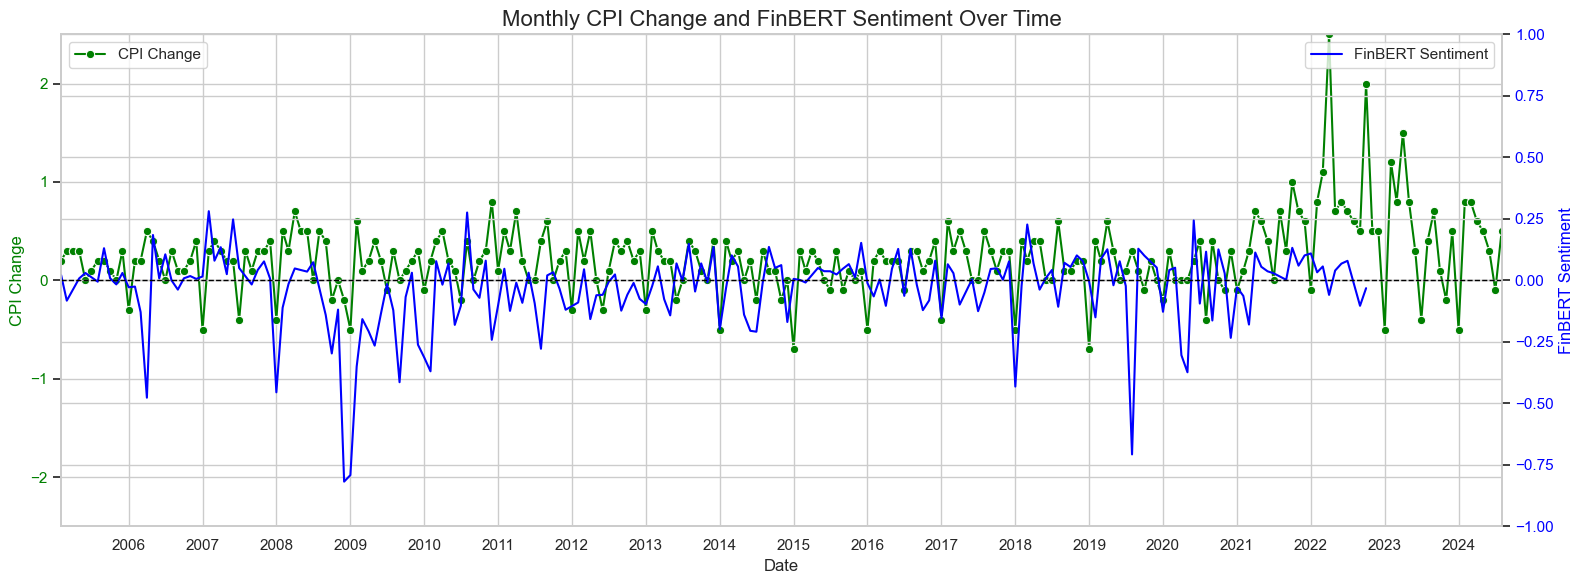

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure the 'YearMonth' column is in datetime format
cpi_monthly['YearMonth'] = pd.to_datetime(cpi_monthly['YearMonth'])

# Create the figure
fig, ax1 = plt.subplots(figsize=(16, 6))

# Line plot for CPI Change on the primary y-axis
sns.lineplot(data=cpi_monthly, x='YearMonth', y='CPI Change', marker='o', color='green', label='CPI Change', ax=ax1)
ax1.set_ylabel('CPI Change', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Manually setting the y-axis limits for CPI Change
ax1.set_ylim(-2.5, 2.5)  

# Create a secondary y-axis for FinBERT Sentiment
ax2 = ax1.twinx() 
sns.lineplot(data=avg_bert_matched, x='year_month', y='finbert_score', color='blue', label='FinBERT Sentiment', ax=ax2)
ax2.set_ylabel('FinBERT Sentiment', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Manually setting the y-axis limits for FinBERT Sentiment
ax2.set_ylim(-1, 1)  

# Adding a horizontal dashed line at y=0 for sentiment on the secondary y-axis
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Adding titles and labels
plt.title('Monthly CPI Change and FinBERT Sentiment Over Time', fontsize=16)

# Set x-axis limits to show only the year
ax1.set_xlim([cpi_monthly['YearMonth'].min(), cpi_monthly['YearMonth'].max()])  

# Format x-axis to show only the year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
ax1.xaxis.set_major_locator(mdates.YearLocator())  
plt.xticks(rotation=45)
ax1.set_xlabel('Date')

# Show grid for the CPI Change plot
ax1.grid(True)

# Display legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


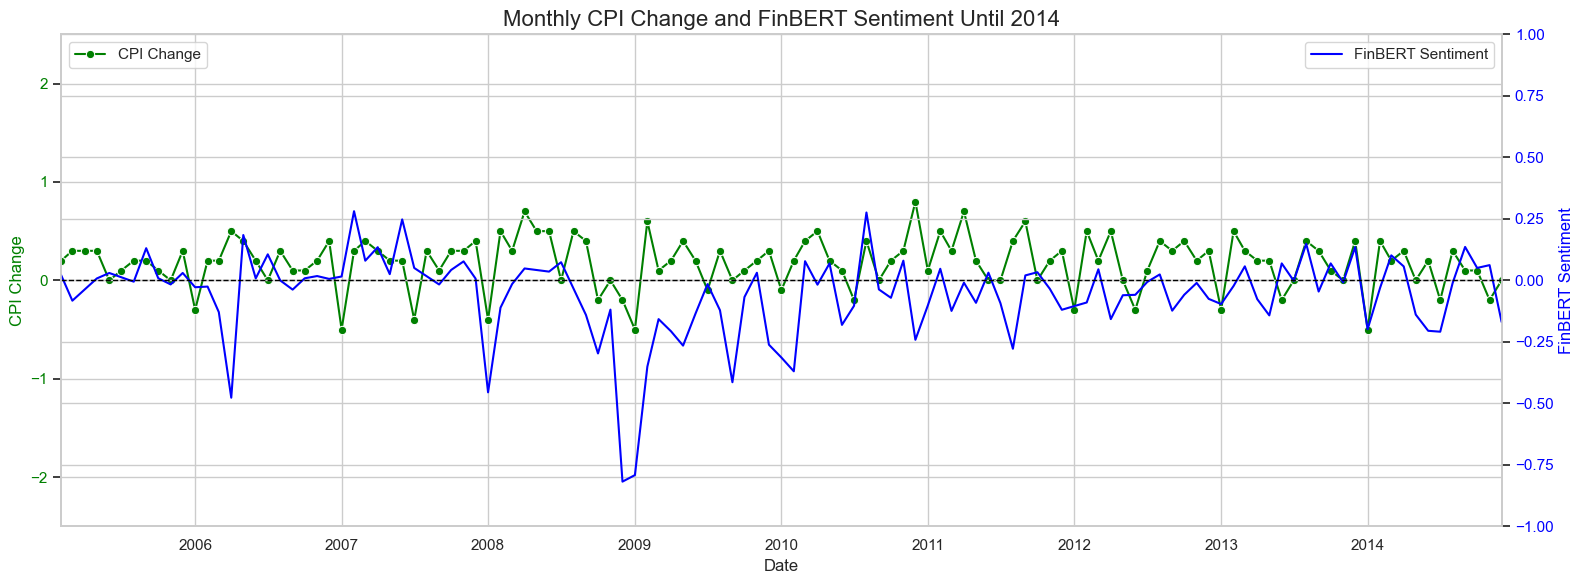

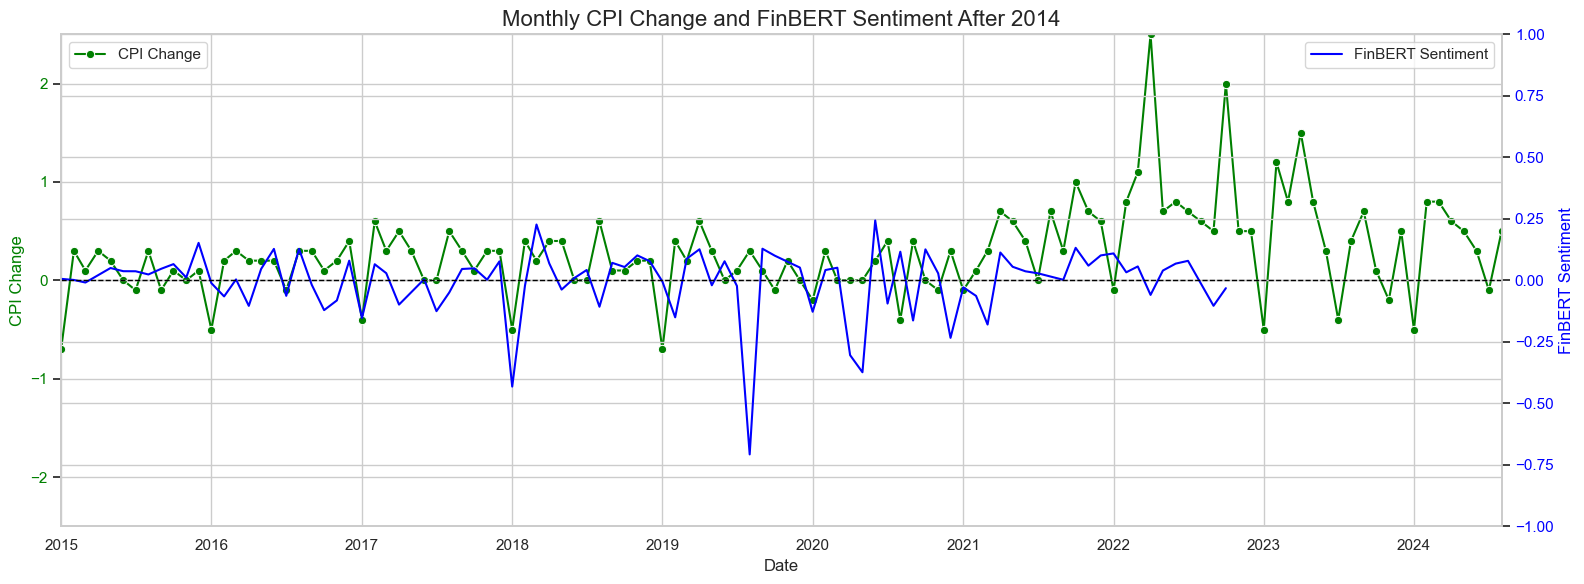

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure the 'YearMonth' column is in datetime format (if not already)
cpi_monthly['YearMonth'] = pd.to_datetime(cpi_monthly['YearMonth'])

# Filter for data up until 2014
cpi_until_2014 = cpi_monthly[cpi_monthly['YearMonth'] <= '2014-12-31']
avg_bert_until_2014 = avg_bert_matched[avg_bert_matched['year_month'] <= '2014-12-31']

# Create the figure for data until 2014
fig, ax1 = plt.subplots(figsize=(16, 6))

# Line plot for CPI Change on the primary y-axis with green color
sns.lineplot(data=cpi_until_2014, x='YearMonth', y='CPI Change', marker='o', color='green', label='CPI Change', ax=ax1)
ax1.set_ylabel('CPI Change', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Manually setting the y-axis limits for CPI Change
ax1.set_ylim(-2.5, 2.5)  

# Create a secondary y-axis for FinBERT Sentiment
ax2 = ax1.twinx()  
sns.lineplot(data=avg_bert_until_2014, x='year_month', y='finbert_score', color='blue', label='FinBERT Sentiment', ax=ax2)
ax2.set_ylabel('FinBERT Sentiment', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Manually setting the y-axis limits for FinBERT Sentiment
ax2.set_ylim(-1, 1) 

# Adding a horizontal dashed line at y=0 for sentiment on the secondary y-axis
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Adding titles and labels
plt.title('Monthly CPI Change and FinBERT Sentiment Until 2014', fontsize=16)

# Set x-axis limits to show only the year range until 2014
ax1.set_xlim([cpi_until_2014['YearMonth'].min(), cpi_until_2014['YearMonth'].max()])

# Format x-axis to show only the year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())  
plt.xticks(rotation=45)
ax1.set_xlabel('Date')  

# Show grid for the CPI Change plot
ax1.grid(True)

# Display legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Filter for data after 2014
cpi_after_2014 = cpi_monthly[cpi_monthly['YearMonth'] > '2014-12-31']
avg_bert_after_2014 = avg_bert_matched[avg_bert_matched['year_month'] > '2014-12-31']

# Create the figure for data after 2014
fig, ax1 = plt.subplots(figsize=(16, 6))

# Line plot for CPI Change on the primary y-axis with green color
sns.lineplot(data=cpi_after_2014, x='YearMonth', y='CPI Change', marker='o', color='green', label='CPI Change', ax=ax1)
ax1.set_ylabel('CPI Change', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Manually setting the y-axis limits for CPI Change
ax1.set_ylim(-2.5, 2.5) 

# Create a secondary y-axis for FinBERT Sentiment
ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
sns.lineplot(data=avg_bert_after_2014, x='year_month', y='finbert_score', color='blue', label='FinBERT Sentiment', ax=ax2)
ax2.set_ylabel('FinBERT Sentiment', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Manually setting the y-axis limits for FinBERT Sentiment
ax2.set_ylim(-1, 1)  

# Adding a horizontal dashed line at y=0 for sentiment on the secondary y-axis
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Adding titles and labels
plt.title('Monthly CPI Change and FinBERT Sentiment After 2014', fontsize=16)

# Set x-axis limits to show only the year range after 2014
ax1.set_xlim([cpi_after_2014['YearMonth'].min(), cpi_after_2014['YearMonth'].max()])

# Format x-axis to show only the year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
ax1.xaxis.set_major_locator(mdates.YearLocator())  
plt.xticks(rotation=45)
ax1.set_xlabel('Date')  

# Show grid for the CPI Change plot
ax1.grid(True)

# Display legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


In [106]:
cpi_monthly['YearMonth'] = pd.to_datetime(cpi_monthly['YearMonth'])
avg_bert_matched['year_month'] = pd.to_datetime(avg_bert_matched['year_month'])

# Merge the two DataFrames based on the date columns
merged_data2 = pd.merge(cpi_monthly[['YearMonth', 'CPI Change']], 
                         avg_bert_matched[['year_month', 'finbert_score']], 
                         left_on='YearMonth', right_on='year_month', how='inner')

# Calculate correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(merged_data2['CPI Change'], merged_data2['finbert_score'])

# Print the results with 4 decimal places
print(f'Correlation Coefficient: {correlation_coefficient:.4f}')
print(f'P-Value: {p_value:.4f}')


Correlation Coefficient: 0.1632
P-Value: 0.0200


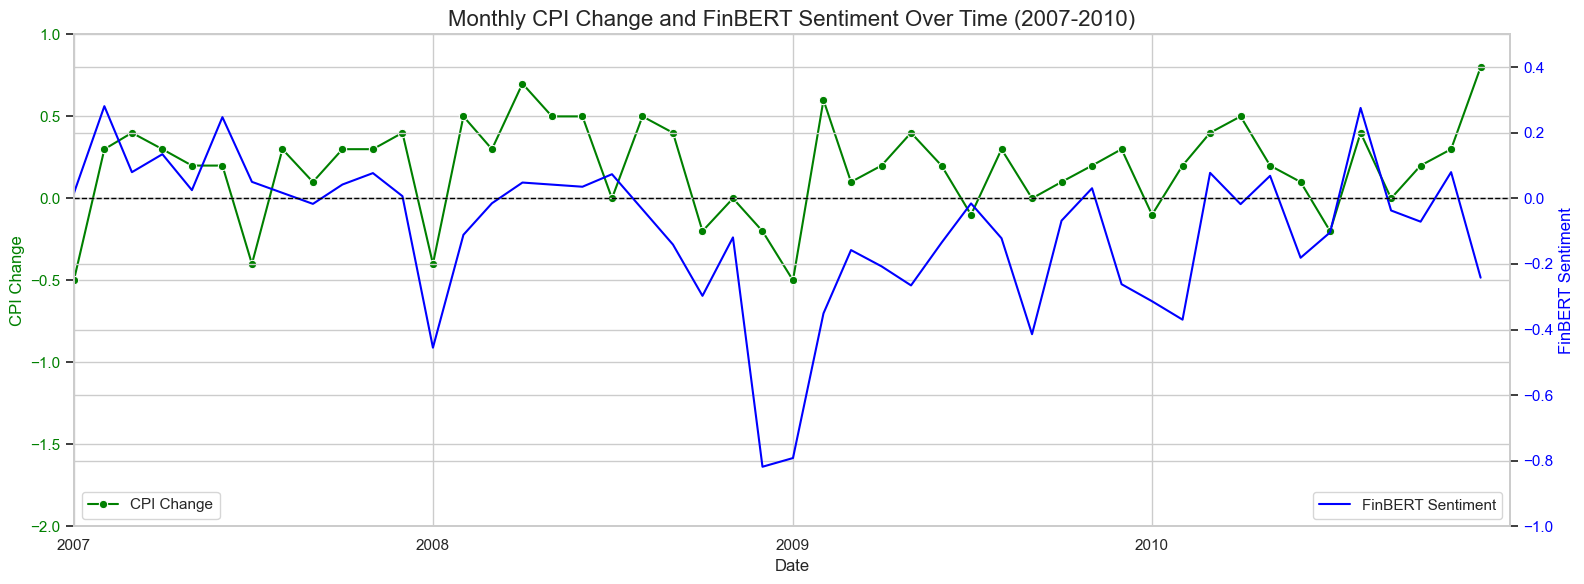

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure the 'YearMonth' column is in datetime format 
cpi_monthly['YearMonth'] = pd.to_datetime(cpi_monthly['YearMonth'])

# Filter data for the desired date range (2007 to 2010)
cpi_filtered = cpi_monthly[(cpi_monthly['YearMonth'] >= '2007-01-01') & (cpi_monthly['YearMonth'] <= '2010-12-31')]
avg_bert_matched_filtered = avg_bert_matched[(avg_bert_matched['year_month'] >= '2007-01-01') & (avg_bert_matched['year_month'] <= '2010-12-31')]

# Create the figure
fig, ax1 = plt.subplots(figsize=(16, 6))

# Line plot for CPI Change on the primary y-axis
sns.lineplot(data=cpi_filtered, x='YearMonth', y='CPI Change', marker='o', color='green', label='CPI Change', ax=ax1)
ax1.set_ylabel('CPI Change', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Manually setting the y-axis limits for CPI Change
ax1.set_ylim(-2, 1)  

# Create a secondary y-axis for FinBERT Sentiment
ax2 = ax1.twinx() 
sns.lineplot(data=avg_bert_matched_filtered, x='year_month', y='finbert_score', color='blue', label='FinBERT Sentiment', ax=ax2)
ax2.set_ylabel('FinBERT Sentiment', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Manually setting the y-axis limits for FinBERT Sentiment
ax2.set_ylim(-1, 0.5)  

# Adding a horizontal dashed line at y=0 for sentiment on the secondary y-axis
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Adding titles and labels
plt.title('Monthly CPI Change and FinBERT Sentiment Over Time (2007-2010)', fontsize=16)

# Set x-axis limits
ax1.set_xlim(pd.to_datetime('2007-01-01'), pd.to_datetime('2010-12-31'))

# Set x-axis label to 'Date'
ax1.set_xlabel('Date')  

# Optional: Format x-axis to show every year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)

# Show grid for the CPI Change plot
ax1.grid(True)

# Display legends at the bottom
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()



In [108]:
cpi_filtered['YearMonth'] = pd.to_datetime(cpi_filtered['YearMonth'], errors='coerce')
avg_bert_matched_filtered['year_month'] = pd.to_datetime(avg_bert_matched_filtered['year_month'], errors='coerce')

# Filter the data for the date range 2007-01-01 to 2010-12-31
cpi_filtered = cpi_filtered[(cpi_filtered['YearMonth'] >= '2007-01-01') & (cpi_filtered['YearMonth'] <= '2010-12-31')]
avg_bert_matched_filtered = avg_bert_matched_filtered[(avg_bert_matched_filtered['year_month'] >= '2007-01-01') & (avg_bert_matched_filtered['year_month'] <= '2010-12-31')]

# Perform the merge on the filtered data
merged_data4 = pd.merge(cpi_filtered, avg_bert_matched_filtered, left_on='YearMonth', right_on='year_month')

# Extract the relevant columns for correlation analysis
cpi_changes = merged_data4['CPI Change']
finbert_scores = merged_data4['finbert_score']

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(cpi_changes, finbert_scores)

# Display the results
print(f'Pearson Correlation Coefficient: {correlation_coefficient:.4f}')
print(f'P-value: {p_value:.4f}')

Pearson Correlation Coefficient: 0.3745
P-value: 0.0113


In [109]:
# Ensure that both 'CPI Change' and 'finbert_score' are numeric
merged_data4['CPI Change'] = pd.to_numeric(merged_data4['CPI Change'], errors='coerce')
merged_data4['finbert_score'] = pd.to_numeric(merged_data4['finbert_score'], errors='coerce')

# Drop rows with NaN values in either 'CPI Change' or 'finbert_score'
merged_data4 = merged_data4.dropna(subset=['CPI Change', 'finbert_score'])

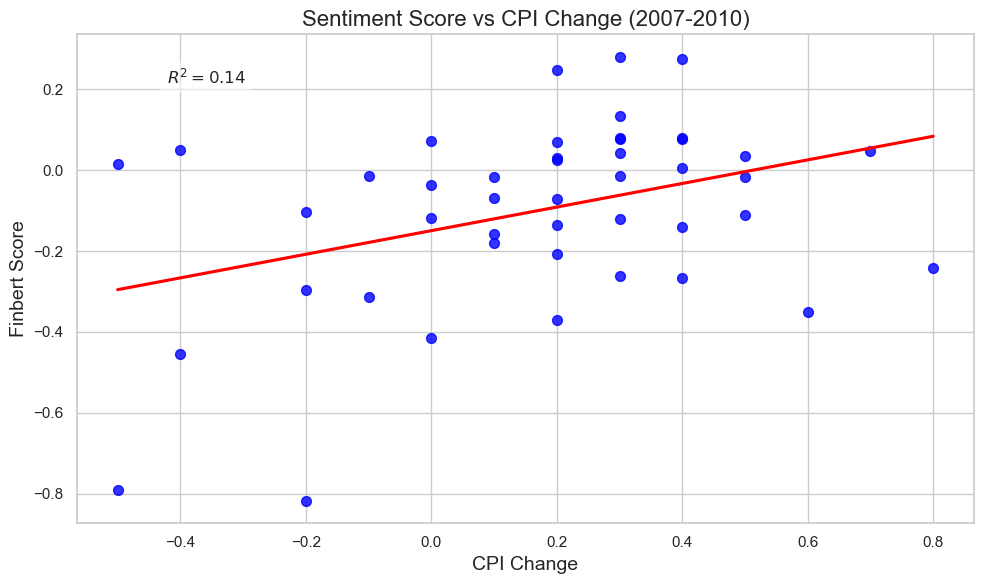

In [110]:
sns.set(style='whitegrid')  
fig, ax = plt.subplots(figsize=(10, 6))

# Scatterplot with regression line using Seaborn
sns.regplot(data=merged_data4, x='CPI Change', y='finbert_score', ax=ax, 
            scatter_kws={'color': 'blue', 's': 50}, 
            line_kws={'color': 'red'}, ci=None)

# Fit Linear Regression Model
X = merged_data4['CPI Change'].values.reshape(-1, 1)  
y = merged_data4['finbert_score'].values
model = LinearRegression().fit(X, y)
r2 = r2_score(y, model.predict(X))

# Display R² on the plot
ax.text(0.1, 0.9, f'$R^2 = {r2:.2f}$', fontsize=12, 
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Set labels and title
ax.set_title('Sentiment Score vs CPI Change (2007-2010)', fontsize=16)
ax.set_xlabel('CPI Change', fontsize=14)
ax.set_ylabel('Finbert Score', fontsize=14)

# Show the plot
plt.tight_layout()  
plt.show()


Low R^2 score at 0.14 hence not used in final presentation

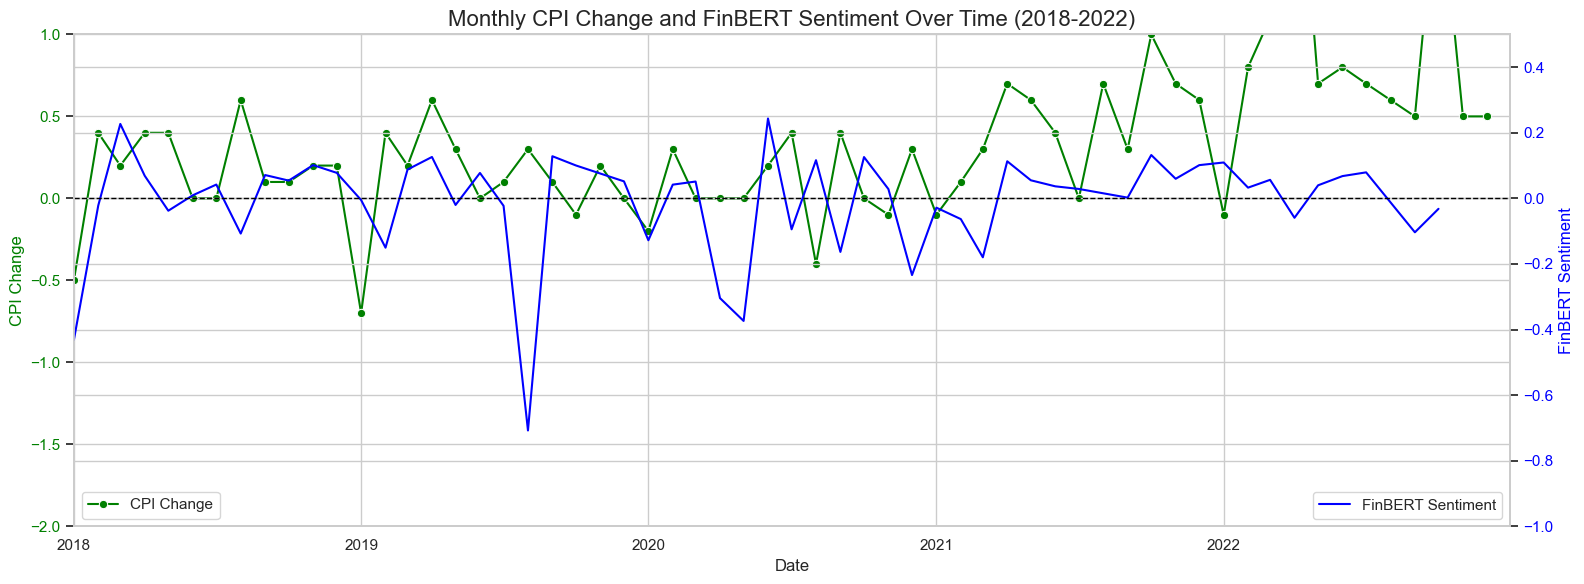

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure the 'YearMonth' column is in datetime format 
cpi_monthly['YearMonth'] = pd.to_datetime(cpi_monthly['YearMonth'])

# Filter data for date range (2018 to 2022)
cpi_filtered = cpi_monthly[(cpi_monthly['YearMonth'] >= '2018-01-01') & (cpi_monthly['YearMonth'] <= '2022-12-31')]
avg_bert_matched_filtered = avg_bert_matched[(avg_bert_matched['year_month'] >= '2018-01-01') & (avg_bert_matched['year_month'] <= '2022-12-31')]

# Create the figure
fig, ax1 = plt.subplots(figsize=(16, 6))

# Line plot for CPI Change on the primary y-axis
sns.lineplot(data=cpi_filtered, x='YearMonth', y='CPI Change', marker='o', color='green', label='CPI Change', ax=ax1)
ax1.set_ylabel('CPI Change', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Manually setting the y-axis limits for CPI Change
ax1.set_ylim(-2, 1)  # Adjust this based on your data

# Create a secondary y-axis for FinBERT Sentiment
ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
sns.lineplot(data=avg_bert_matched_filtered, x='year_month', y='finbert_score', color='blue', label='FinBERT Sentiment', ax=ax2)
ax2.set_ylabel('FinBERT Sentiment', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Manually setting the y-axis limits for FinBERT Sentiment
ax2.set_ylim(-1, 0.5) 

# Adding a horizontal dashed line at y=0 for sentiment on the secondary y-axis
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Adding titles and labels
plt.title('Monthly CPI Change and FinBERT Sentiment Over Time (2018-2022)', fontsize=16)

# Set x-axis limits
ax1.set_xlim(pd.to_datetime('2018-01-01'), pd.to_datetime('2022-12-31'))

# Set x-axis label to 'Date'
ax1.set_xlabel('Date') 

# Optional: Format x-axis to show every year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)

# Show grid for the CPI Change plot
ax1.grid(True)

# Display legends at the bottom
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [112]:
merged_data5 = pd.merge(cpi_filtered, avg_bert_matched_filtered, left_on='YearMonth', right_on='year_month')

# Extract the relevant columns for correlation analysis
cpi_changes = merged_data5['CPI Change']
finbert_scores = merged_data5['finbert_score']

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(cpi_changes, finbert_scores)

# Display the results
print(f'Pearson Correlation Coefficient: {correlation_coefficient:.4f}')
print(f'P-value: {p_value:.4f}')

Pearson Correlation Coefficient: 0.0786
P-value: 0.5682
